In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}


<IPython.core.display.Javascript object>

In [13]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import sqlite3
from scipy.optimize import curve_fit
from tqdm import tqdm


%matplotlib inline 



# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr1 = [(0.00, 0.00, 0.00),
      (1.00, 0.82, 0.67),
      (0.31, 0.24, 0.00),
      (0.45, 0.70, 0.90),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (1.00, 0.00, 0.00)]

Clr = ['#004A98',
       '#C5C5C5',
       '#FF538C',
       '#4DC6FF',
       '#FFA42C',
       '#C050FF',
       '#75FF84',
       '#C70000',
       '#3D98C3',
       '#5D5D5D'
       ]


Fibonacci = np.array([0,1, 2, 3, 5, 8, 13, 21, 34, 55, 89]).astype(float)

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 30}


plt.rc('font', **font)
# plt.rc('text', usetex=True)

# Make dictionary with Swamis runs

In [14]:
CDELT1 = 0.504298
Rs = 953.517029
Rsun = 696000000
DOBS = 150559255066.71

life_cut = 10

features = {}
for i in range(10):
    time = 45*2**i

    # Feature = pd.read_pickle(f'data\SWAMIS\swamis_{str(time).zfill(5)}_RA_SF.pnds')
    Feature = pd.read_pickle(f'data/SWAMIS/100_frames/swamis_{str(time).zfill(5)}s_RA.pnds')

    print(np.nanmin(Feature['Life']))

    # Converting flux to maxwells
    Feature['Flux'] = Feature['Flux']*(CDELT1*Feature['scale'])**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2*Feature['scale']
    # Feature['Flux'] = Feature['Flux']*(CDELT1)**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2

    # Add distance from disk center in arcseconds
    Feature['Dis'] = np.sqrt(Feature['xs']**2+Feature['ys']**2)
    Feature['Ang'] = -(Feature['Dis']/60/60*np.pi/180- np.arcsin(np.sin(Feature['Dis']/60/60*np.pi/180)*DOBS/Rsun))
    Feature['Area'] = 2*np.pi*(Rsun/1000000)**2*Feature['size_s']/(np.pi*Rs**2)*np.divide(1,np.cos(Feature['Ang']))
    Feature['meanB'] = np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)

    Feature = Feature.loc[Feature['Life']<np.nanmax(Feature['Life']), :]

    if i>0:
        Feature = Feature.loc[Feature['Life']>life_cut, :]

    Feature['Life'] = (Feature['Life']-1)*time/60/60

    features[time] = {}

    features[time]['features'] = Feature


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [15]:
def trunc_ln(x, si, mu, tr):
    return 1/(x*si*np.sqrt(np.pi))*np.exp(-np.power(np.log(x)-mu,2)/(2*si**2))

def trunc_wb(x, k, l, tr):
     return np.divide(k/l*np.power(x/l,k-1)*np.exp(-np.power(x/l,k)),
                     np.exp(-np.power(tr/l,k)))

class lognorm_weibull(stats.rv_continuous):
    def _argcheck(self, c, si, mu, k, l, tr):
        return (c>=0 and c<=1) and (si > 0) and (l>0) and (k>0) and (tr>0) and (mu>0)
    def _pdf(self, x, c, si, mu, k, l, tr):
            return c*trunc_ln(x, si, mu, tr) + (1-c)*trunc_wb(x, k, l, tr)

class lognorm_tr(stats.rv_continuous):
    def _argcheck(self, si, mu, tr):
        return (si > 0) and (mu>0)
    def _pdf(self, x, si, mu, tr):
            return trunc_ln(x, si, mu, tr)
        
class wb_tr(stats.rv_continuous):
    def _argcheck(self, k, l, tr):
        return (k > 0) and (l>0)
    def _pdf(self, x, k, l, tr):
            return trunc_wb(x, k, l, tr)
    
wbtr = wb_tr()
lntr = lognorm_tr()
lnwb = lognorm_weibull()  

In [16]:
# lntr = lognorm_tr()
# lntr.fit(Feature['Area'][Feature['Area']>20], 1, 1, ftr=20, floc=0, fscale=1)

In [17]:
# lnwb = lognorm_weibull()   
    
# lnwb.fit(Feature['Area'][Feature['Area']>100], 0.5, 0.9200010390498645, 4.147854097567208, 0.9211678259779241, 103.59611121389516, fc=0.9, fk = 0.6, ftr=20, floc=0, fscale=1)

1.1875
1.4330503224848898e-08 1.0
2.375
1.2116006360798433e-05 1.0


C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\2714551982.py:99: RuntimeWarning: invalid value encountered in divide
  hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\2714551982.py:104: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


4.75
7.109010623404556e-06 1.0
9.5
6.701451130913795e-06 1.0
19.0
1.3936073648313778e-05 1.0
38.0
2.6332078824550184e-05 1.0
76.0
8.468108151081879e-05 1.0
148.8
8.077914251433348e-05 1.0
256.0
0.0002253436814453768 1.0
275.2
0.0024267590172315154 1.0


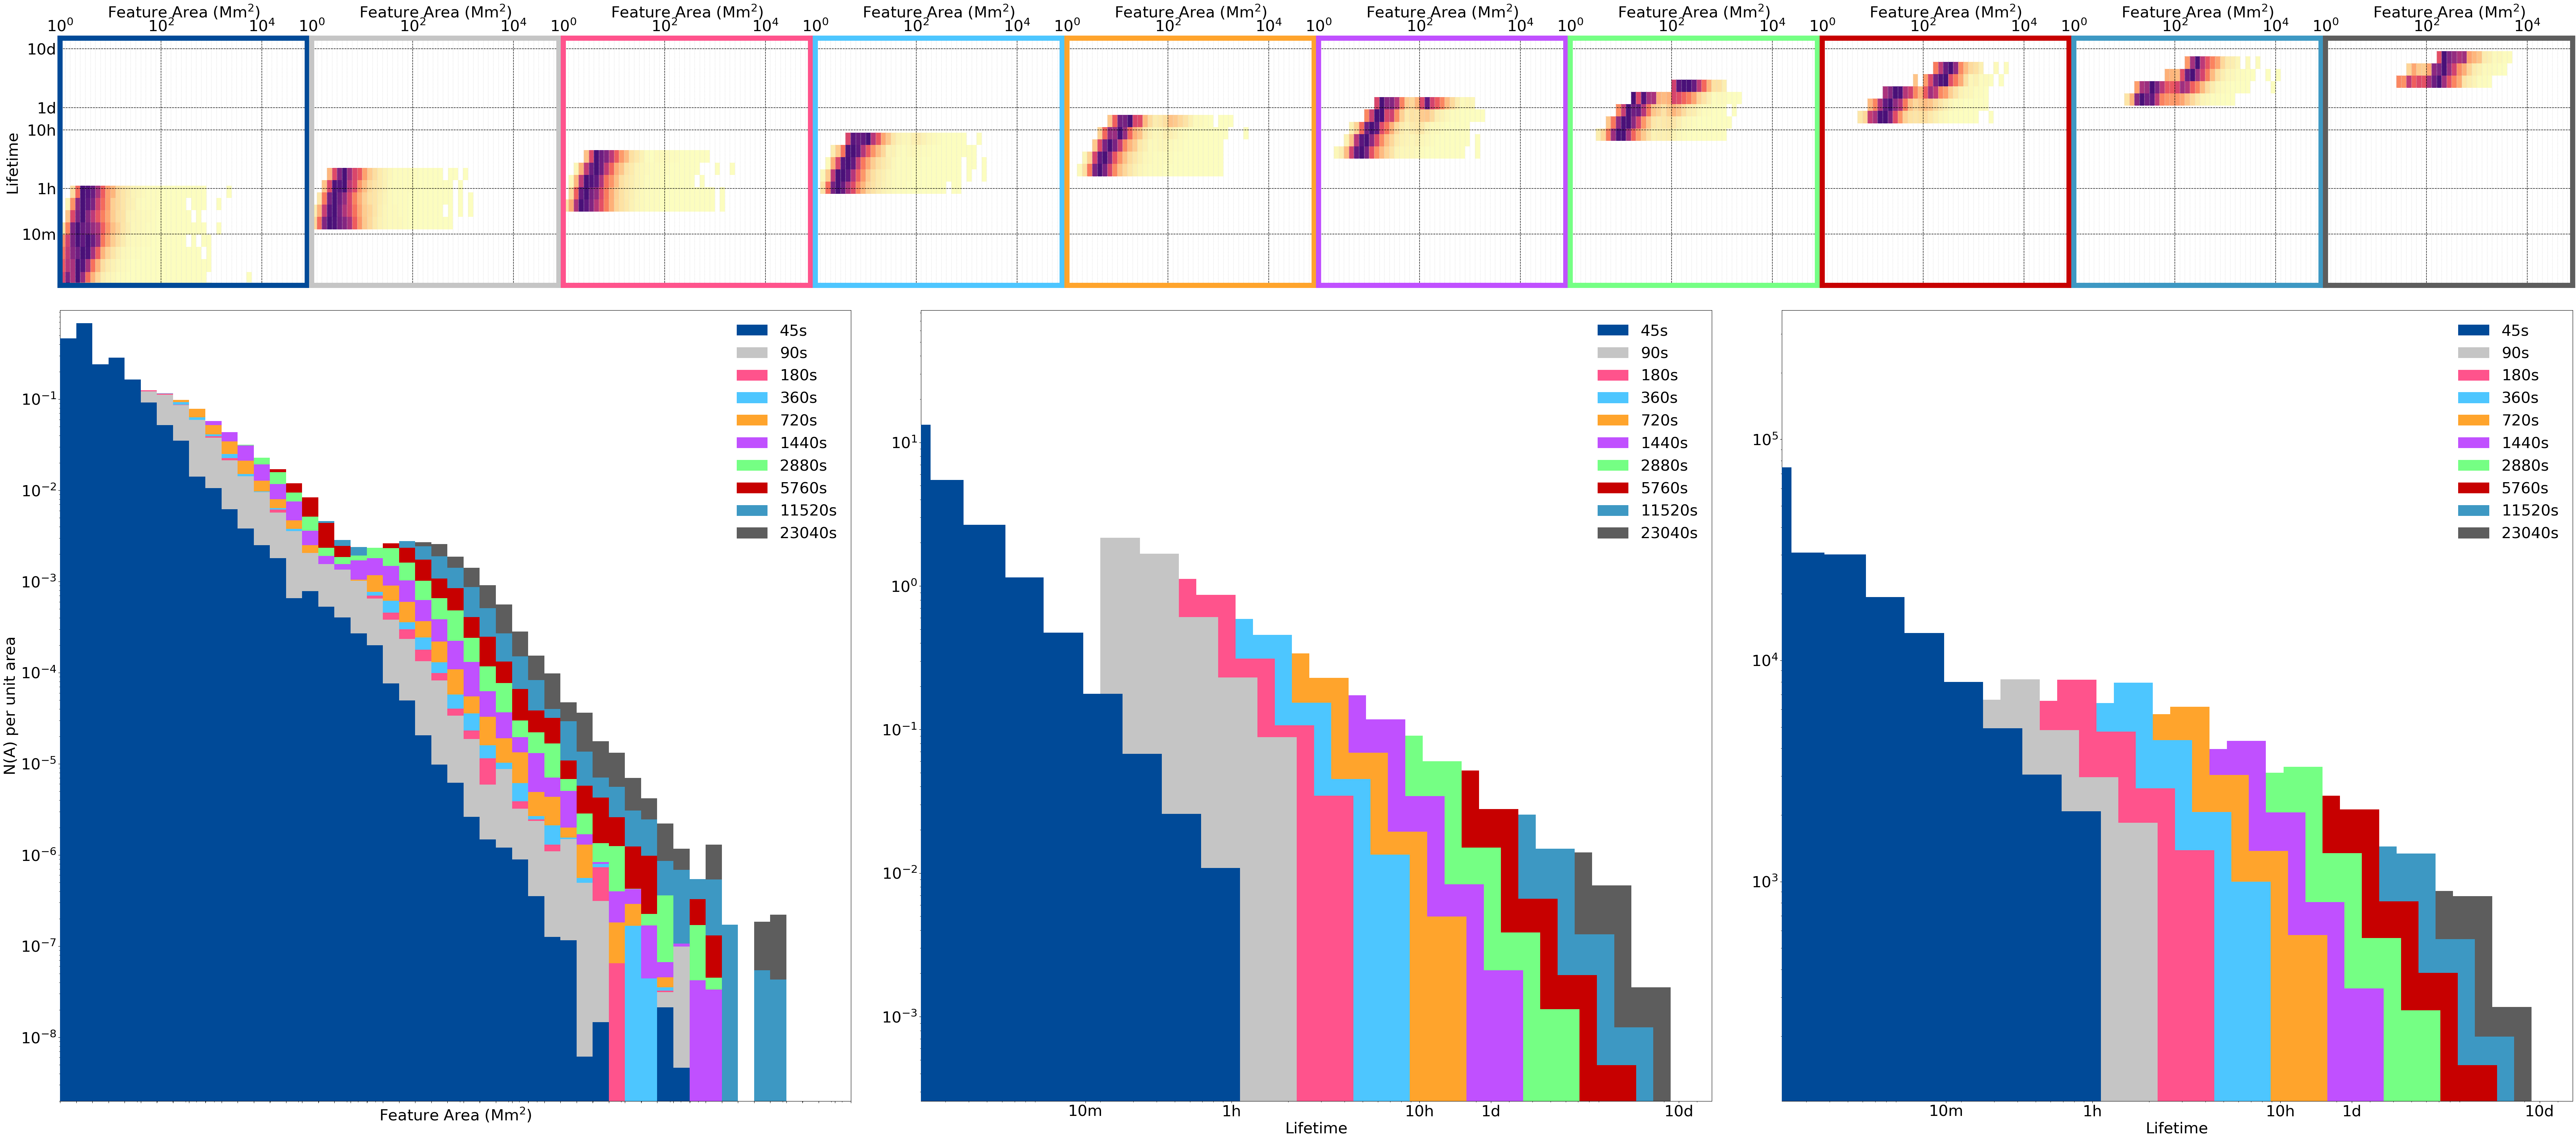

In [18]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (10*ppxx + 9*ppadh2 - ppadh3*2)/3




## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax4 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])


for i in range(10):
    time = 45*2**i

    Feature = features[time]['features']

    Nbins = 60

    T1 = 1/45
    T2 = 360
    # edgesT = np.arange(T1,T2)
    # edgesT = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))
    edgesT = Fibonacci*time/60/60
    edgesT = edgesT[edgesT<=np.nanmax(Feature['Life'])]
    # if np.max(edgesT)<np.nanmax(Feature['Life']):
    #     edgesT = np.concatenate((edgesT, np.nanmax(Feature['Life'])[None]))



    Nbins = 50
    A1 = 1
    A2 = 1e5
    edgesA = np.power(10,np.arange(np.log10(A1),np.log10(A2),(np.log10(A2)-np.log10(A1))/Nbins))


    # Scatter Plot
    ax3 = fig.add_axes([ppadh+(ppxx+ppadh2)*i, ppadv, ppxx, ppxy])

    histout = np.histogram2d(Feature['Area'], Feature['Life'], bins = [edgesA,edgesT])

    print(np.nanmax(Feature['Life']))

    # widthsT = edgesT[1:]-edgesT[0:-1]
    # hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


    widthsA = edgesA[1:]-edgesA[0:-1]
    hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

    hst_nrmA[histout[0]<=2] = np.nan
    hst_nrmA = hst_nrmA.T

    hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


    #--------
    # Storing matrices
    features[time]['hst'] = histout[0].T
    features[time]['hst_nrmA'] = hst_nrmA
    features[time]['hst_nrmA_clrN'] = hst_nrmA_clrN
    features[time]['edgesT'] = edgesT

    print(np.nanmin(hst_nrmA_clrN), np.nanmax(hst_nrmA_clrN))
    


    # ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
    ax3.pcolormesh(edgesA, edgesT, hst_nrmA_clrN, cmap=plt.cm.magma_r, vmax=1.3)
    # ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(bottom = T1, top = T2);
    ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
    # ax3.set_xticklabels([])

    ax3.set_xlabel('Feature Area (Mm$^2$)')



    ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax3.xaxis.tick_top()
    ax3.minorticks_on()
    ax3.set_xticks(edgesA, minor=True)
    ax3.set_xticklabels([], minor=True);
    ax3.xaxis.set_label_position('top')

    ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)
    

    if i==0 or i==7:
        ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
        ax3.set_ylabel('Lifetime')
    else:
        ax3.set_yticklabels(['', '', '', '', ''] , minor=False)

    if i==7:
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position('right')

    ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    plt.setp(ax3.spines.values(), color=Clr[i], linewidth=10)        


    ax1.hist(Feature['Area'], bins = edgesA, color=Clr[i], alpha=1, density = True, label=f'{time}s', zorder = 8-i)
    ax2.hist(Feature['Life'], bins = edgesT, color=Clr[i], alpha=1, density = True, label=f'{time}s', zorder=8-i)
    ax4.hist(Feature['Life'], bins = edgesT, color=Clr[i], alpha=1, density = False, label=f'{time}s', zorder=8-i)



ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

ax1.set_xticks(edgesA, minor=False)
ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('Feature Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = T1, right = T2);

ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax2.set_xlabel('Lifetime');



ax4.legend(frameon=False)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left = T1, right = T2);

ax4.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax4.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax4.set_xlabel('Lifetime');



# fig.savefig('Area_lifetime_RotAssoc.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## Combine series

In [19]:
Nbins = 60

T1 = 1/45
T2 = 360
edgesT_comb = np.arange(T1,T2)
edgesT_comb = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))

combined_features = features[45]['features'].copy()

for i in tqdm(np.arange(1, edgesT_comb.shape[0])):

    for j in range(1,10):
        time = 45*2**j
        Feature = features[time]['features'].copy()

        n_combined = np.sum(np.logical_and(combined_features['Life']>edgesT_comb[i-1], combined_features['Life']<=edgesT_comb[i]))
        n_feature = np.sum(np.logical_and(Feature['Life']>edgesT_comb[i-1], Feature['Life']<=edgesT_comb[i]))

        if n_feature > n_combined:
            # Remove current features
            combined_features = combined_features.loc[np.logical_or(combined_features['Life']<=edgesT_comb[i-1], combined_features['Life']>edgesT_comb[i])]

            # Append new features
            combined_features = pd.concat([combined_features, Feature.loc[np.logical_and(Feature['Life']>edgesT_comb[i-1], Feature['Life']<=edgesT_comb[i]), :]]).reset_index(drop=True)

combined_features

100%|██████████| 59/59 [00:28<00:00,  2.04it/s]


id     Life  scale                        Flux        Lat   
0            1    0.075    1.0      -4759822700975201280.0 -73.460572  \
1            3    0.000    1.0      -1087405404169819776.0 -73.077809   
2            4    0.000    1.0      -2018065178609808896.0 -72.768028   
3            5    0.000    1.0      -1116581260832069888.0 -72.902785   
4            6    0.000    1.0      -2535889598937476096.0 -72.790183   
...        ...      ...    ...                         ...        ...   
512176   89840  262.400    8.0 -131567333012699202191360.0  -6.312025   
512177  483111  262.400    8.0  161228280162454104702976.0  13.566397   
512178  536694  275.200    8.0  411974428257624399020032.0   7.160759   
512179  593178  275.200    8.0  313883870133907380764672.0 -12.004643   
512180  636819  268.800    8.0 -305663447922696762949632.0 -16.238727   

              Lon            x      xerr            y      yerr  MaxSize   
0      -14.117696  2168.980583  0.287084  3815.946495  0.308943      7.0  \
1       -0.515724  2042.486745  0.499824  3810.000000  0.000086      2.0   
2       21.967109  1827.657345  0.335591  3809.082584  0.570318      3.0   
3       16.705742  1877.470658  0.499138  3809.470658  0.499138      2.0   
4       16.083357  1882.287636  0.261344  3807.993468  0.392628      4.0   
...           ...          ...       ...          ...       ...      ...   
512176  -7.618770   225.331928  0.229859   245.613659  0.298264    445.0   
512177 -11.947121   209.021639  0.365970   323.152834  0.274263    614.0   
512178 -43.864058    94.179091  0.337815   294.422192  0.494985   1161.0   
512179 -18.147142   184.604070  0.450067   217.586695  0.397777   1405.0   
512180  -9.095461   220.774102  0.492820   200.125828  0.426952   1482.0   

                xs          ys        size_s         maxB         Dis   
0       -66.316219 -891.486901      1.780222  -114.530262  893.950075  \
1        -2.502384 -888.572155      0.508633   -74.707427  888.575678   
2       105.836138 -888.242242      0.762949   -95.060790  894.525331   
3        80.715163 -888.407168      0.508633   -77.163422  892.066272   
4        78.286886 -887.659248      1.017266   -95.803365  891.104807   
...            ...         ...           ...          ...         ...   
512176 -126.010812  -39.540032   7260.742295 -1541.214259  132.068690   
512177 -192.095230  273.905392  10018.446611  1544.279964  334.551552   
512178 -655.732833  157.839443  18943.680599  1595.305406  674.461888   
512179 -290.704646 -152.517340  22924.664272  1682.740000  328.284526   
512180 -144.735895 -222.922976  24181.203045  -976.047331  265.787759   

             Ang          Area        meanB  
0       1.211126      5.389714    88.313077  
1       1.195290      1.477860    73.579738  
2       1.212862      2.320581    86.963773  
3       1.205499      1.517233    73.593257  
4       1.202660      3.012115     84.18967  
...          ...           ...          ...  
512176  0.138314   7811.601597  1684.255544  
512177  0.356869  11393.433343  1415.098288  
512178  0.782462  28464.223708  1447.341169  
512179  0.349890  26003.940808    1207.0627  
512180  0.281199  26820.761957  1139.652365  

[512181 rows x 19 columns]

In [20]:
combined_features['Area']

0             5.389714
1             1.477860
2             2.320581
3             1.517233
4             3.012115
              ...     
512176     7811.601597
512177    11393.433343
512178    28464.223708
512179    26003.940808
512180    26820.761957
Name: Area, Length: 512181, dtype: float64

C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\3272622657.py:120: RuntimeWarning: invalid value encountered in divide
  hst_nrmA_comb = (histout[0]/widthsA_comb[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\3272622657.py:125: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN_comb = hst_nrmA_comb/np.nanmax(hst_nrmA_comb,axis=1)[:,None]


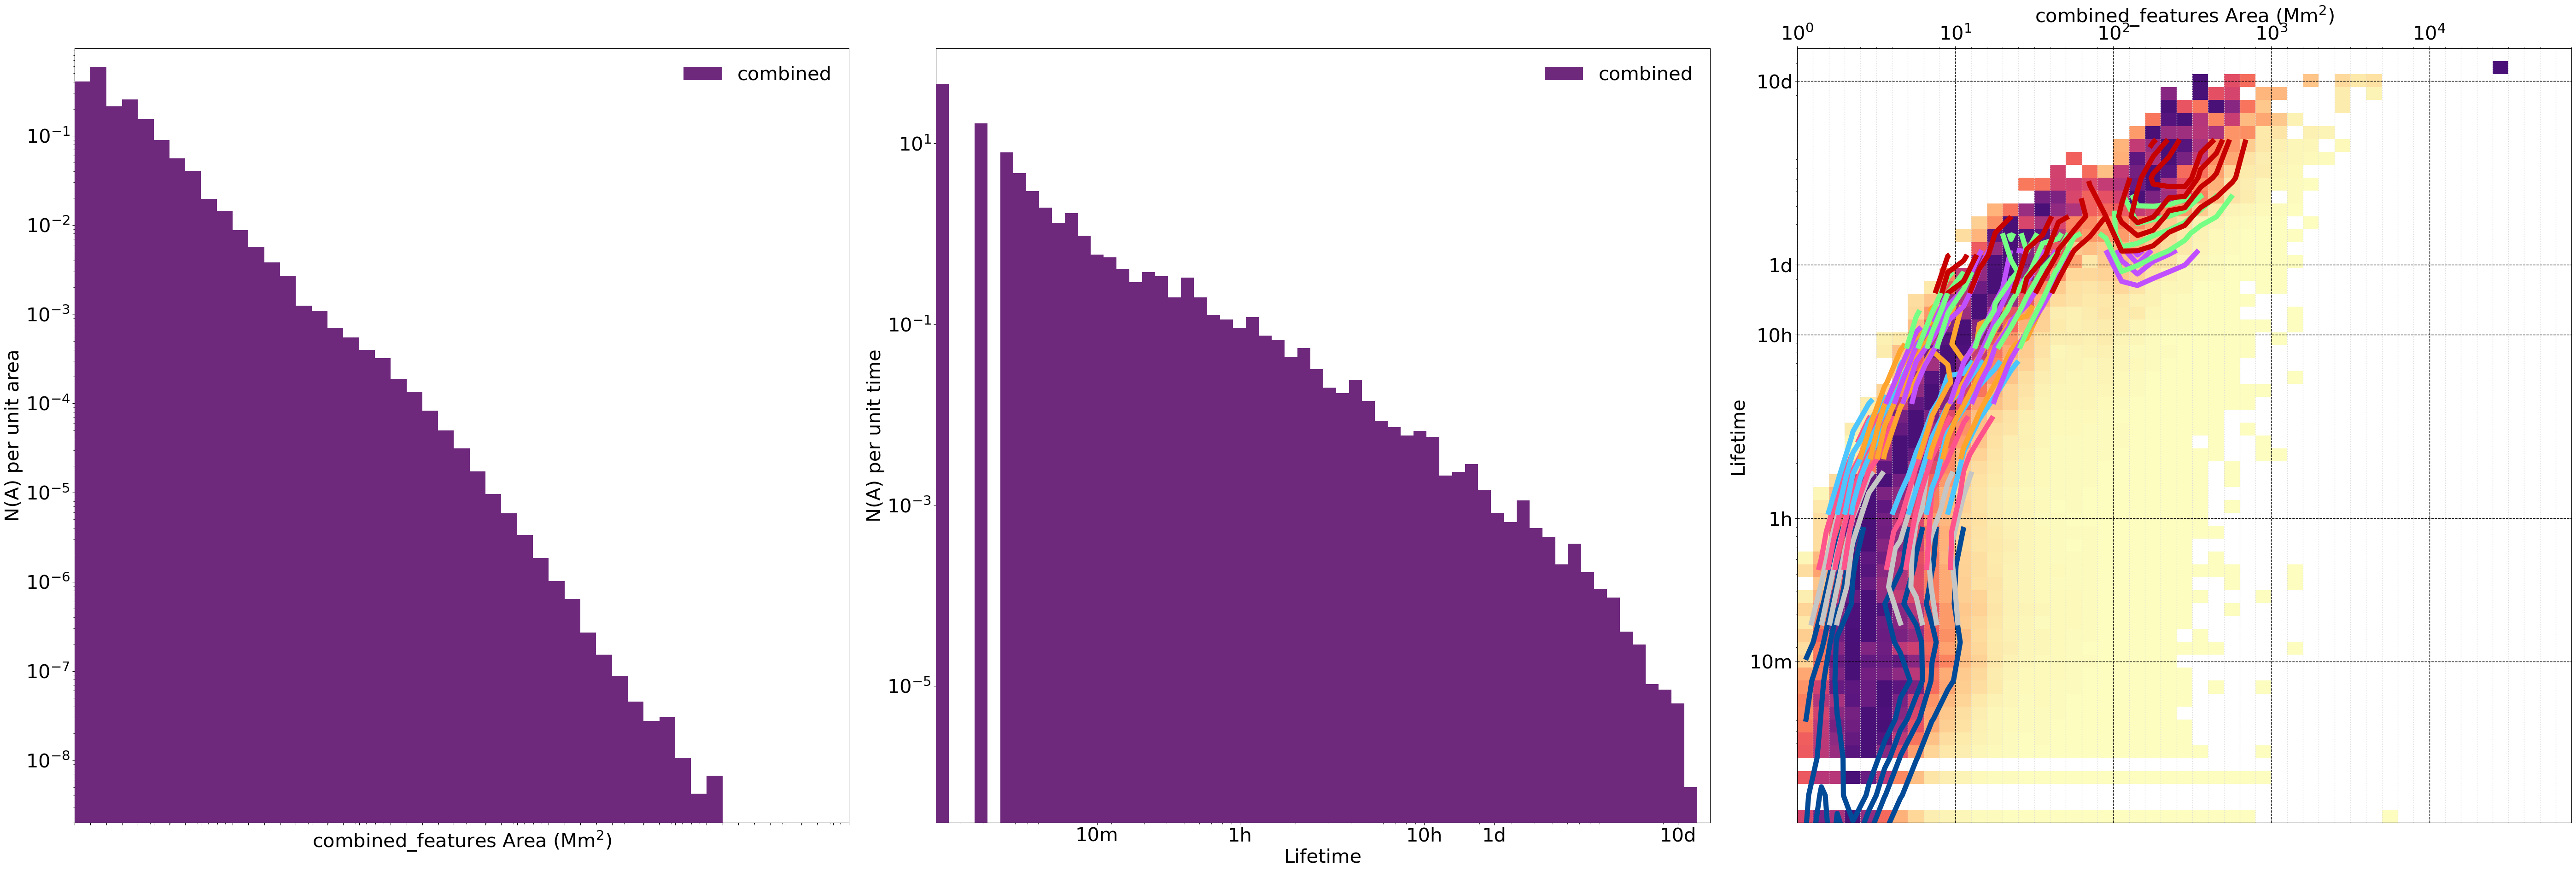

In [27]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

i=1

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (8*ppxx + 7*ppadh2 - ppadh3*2)/3




## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax3 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
 


ax1.hist(combined_features['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 8-i)
ax2.hist(combined_features['Life'], bins = edgesT_comb, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder=8-i)



ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

ax1.set_xticks(edgesA, minor=False)
ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('combined_features Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = T1, right = T2);

ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax2.set_xlabel('Lifetime');
ax2.set_ylabel('N(A) per unit time')



ax4.legend(frameon=False)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left = T1, right = T2);

ax4.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax4.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax4.set_xlabel('Lifetime');





histout = np.histogram2d(combined_features['Area'], combined_features['Life'], bins = [edgesA,edgesT_comb])


# widthsT = edgesT_comb[1:]-edgesT_comb[0:-1]
# hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


widthsA_comb = edgesA[1:]-edgesA[0:-1]
hst_nrmA_comb = (histout[0]/widthsA_comb[:,None])/histout[0].sum(0)[None,:]

hst_nrmA_comb[histout[0]<=2] = np.nan
hst_nrmA_comb = hst_nrmA_comb.T

hst_nrmA_clrN_comb = hst_nrmA_comb/np.nanmax(hst_nrmA_comb,axis=1)[:,None]
hst_nrmA_clrN_comb = hst_nrmA_clrN_comb.copy()




# ax3.pcolormesh(edgesA, edgesT_comb, hist_normA, cmap=plt.cm.magma_r)
ax3.pcolormesh(edgesA, edgesT_comb, hst_nrmA_clrN_comb, cmap=plt.cm.magma_r, vmax=1.3)
# ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(bottom = T1, top = T2);
ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax3.set_xlabel('combined_features Area (Mm$^2$)')


for i in range(8):
    time = 45*2**i

    ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (features[time]['edgesT'][0:-1]+features[time]['edgesT'][1:])/2, features[time]['hst_nrmA_clrN'], np.linspace(0,1,6), colors=Clr[i], linewidths=8)

ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax3.xaxis.tick_top()
ax3.minorticks_on()
ax3.set_xticks(edgesA, minor=True)
ax3.set_xticklabels([], minor=True);
ax3.xaxis.set_label_position('top')

ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)
ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax3.set_ylabel('Lifetime')

# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position('right')

ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')


# fig.savefig('Area_lifetime_Combined.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## True combined series

In [25]:
true_combined = pd.read_pickle('data\SWAMIS\\100_frames\swamis_all_combined_45-23040_SF.pnds')

# Add distance from disk center in arcseconds
true_combined['Dis'] = np.sqrt(true_combined['xs']**2+true_combined['ys']**2)
true_combined['Ang'] = -(true_combined['Dis']/60/60*np.pi/180- np.arcsin(np.sin(true_combined['Dis']/60/60*np.pi/180)*DOBS/Rsun))
true_combined['Area'] = 2*np.pi*(Rsun/1000000)**2*true_combined['size_s']/(np.pi*Rs**2)*np.divide(1,np.cos(true_combined['Ang']))
true_combined['meanB'] = np.divide(np.abs(true_combined['Flux']),true_combined['Area']*100000000**2)

true_combined

id    Life  scale         Flux        Lat        Lon   
0             1   0.075    1.0 -1756.405210 -73.460572 -14.117696  \
1             3   0.000    1.0  -401.259592 -73.077809  -0.515724   
2             4   0.000    1.0  -744.679039 -72.768028  21.967109   
3             5   0.000    1.0  -412.025671 -72.902785  16.705742   
4             6   0.000    1.0  -935.759582 -72.790183  16.083357   
...         ...     ...    ...          ...        ...        ...   
483827  8196426  64.000    8.0  1240.328246 -14.212224  60.654953   
483828  8196431  64.000    8.0  1417.217418 -12.101807 -44.927955   
483829  8196495  64.000    8.0   707.559467  13.522672 -33.939155   
483830  8196513  64.000    8.0  1436.398568  22.650935 -36.866520   
483831  8196534  64.000    8.0   204.344574  32.291842  15.045237   

                  x      xerr            y      yerr  ...          xs   
0       2168.980583  0.287084  3815.946495  0.308943  ...  -66.316219  \
1       2042.486745  0.499824  3810.000000  0.000086  ...   -2.502384   
2       1827.657345  0.335591  3809.082584  0.570318  ...  105.836138   
3       1877.470658  0.499138  3809.470658  0.499138  ...   80.715163   
4       1882.287636  0.261344  3807.993468  0.392628  ...   78.286886   
...             ...       ...          ...       ...  ...         ...   
483827   455.364297  0.198822   201.135379  0.364870  ...  802.715213   
483828    94.047507  0.578695   211.514801  0.252520  ... -656.746771   
483829   128.762686  0.193841   316.821372  0.376565  ... -516.518617   
483830   126.207875  0.329989   352.162515  0.272863  ... -526.810704   
483831   308.322803  0.233774   387.175043  0.360989  ...  208.756269   

                ys      size_s        maxB  Timeline   Origin         Dis   
0      -891.486901    1.780222 -114.530262      0.05     45.0  893.950075  \
1      -888.572155    0.508633  -74.707427      0.00     45.0  888.575678   
2      -888.242242    0.762949  -95.060790      0.00     45.0  894.525331   
3      -888.407168    0.508633  -77.163422      0.00     45.0  892.066272   
4      -887.659248    1.017266  -95.803365      0.00     45.0  891.104807   
...            ...         ...         ...       ...      ...         ...   
483827 -218.675513  179.483995   83.694510    595.20  23040.0  831.967964   
483828 -176.761835  277.383439  126.062100    569.60  23040.0  680.118422   
483829  248.612492  146.850056  126.119683    569.60  23040.0  573.236123   
483830  391.360386  310.017387  136.423972    556.80  23040.0  656.271643   
483831  532.812518   81.583634   47.363181    595.20  23040.0  572.248512   

             Ang        Area         meanB  
0       1.211126    5.389714  3.258809e-14  
1       1.195290    1.477860  2.715140e-14  
2       1.212862    2.320581  3.209019e-14  
3       1.205499    1.517233  2.715639e-14  
4       1.202660    3.012115  3.106653e-14  
...          ...         ...           ...  
483827  1.056316  388.668488  3.191224e-16  
483828  0.790862  420.313251  3.371812e-16  
483829  0.642200  195.412630  3.620848e-16  
483830  0.755914  454.002268  3.163858e-16  
483831  0.640910  108.458314  1.884084e-16  

[483832 rows x 21 columns]

C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\3554944588.py:104: RuntimeWarning: invalid value encountered in divide
  hst_nrmA_combt = (histout[0]/widthsA_combt[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_503812\3554944588.py:109: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN_combt = hst_nrmA_combt/np.nanmax(hst_nrmA_combt,axis=1)[:,None]


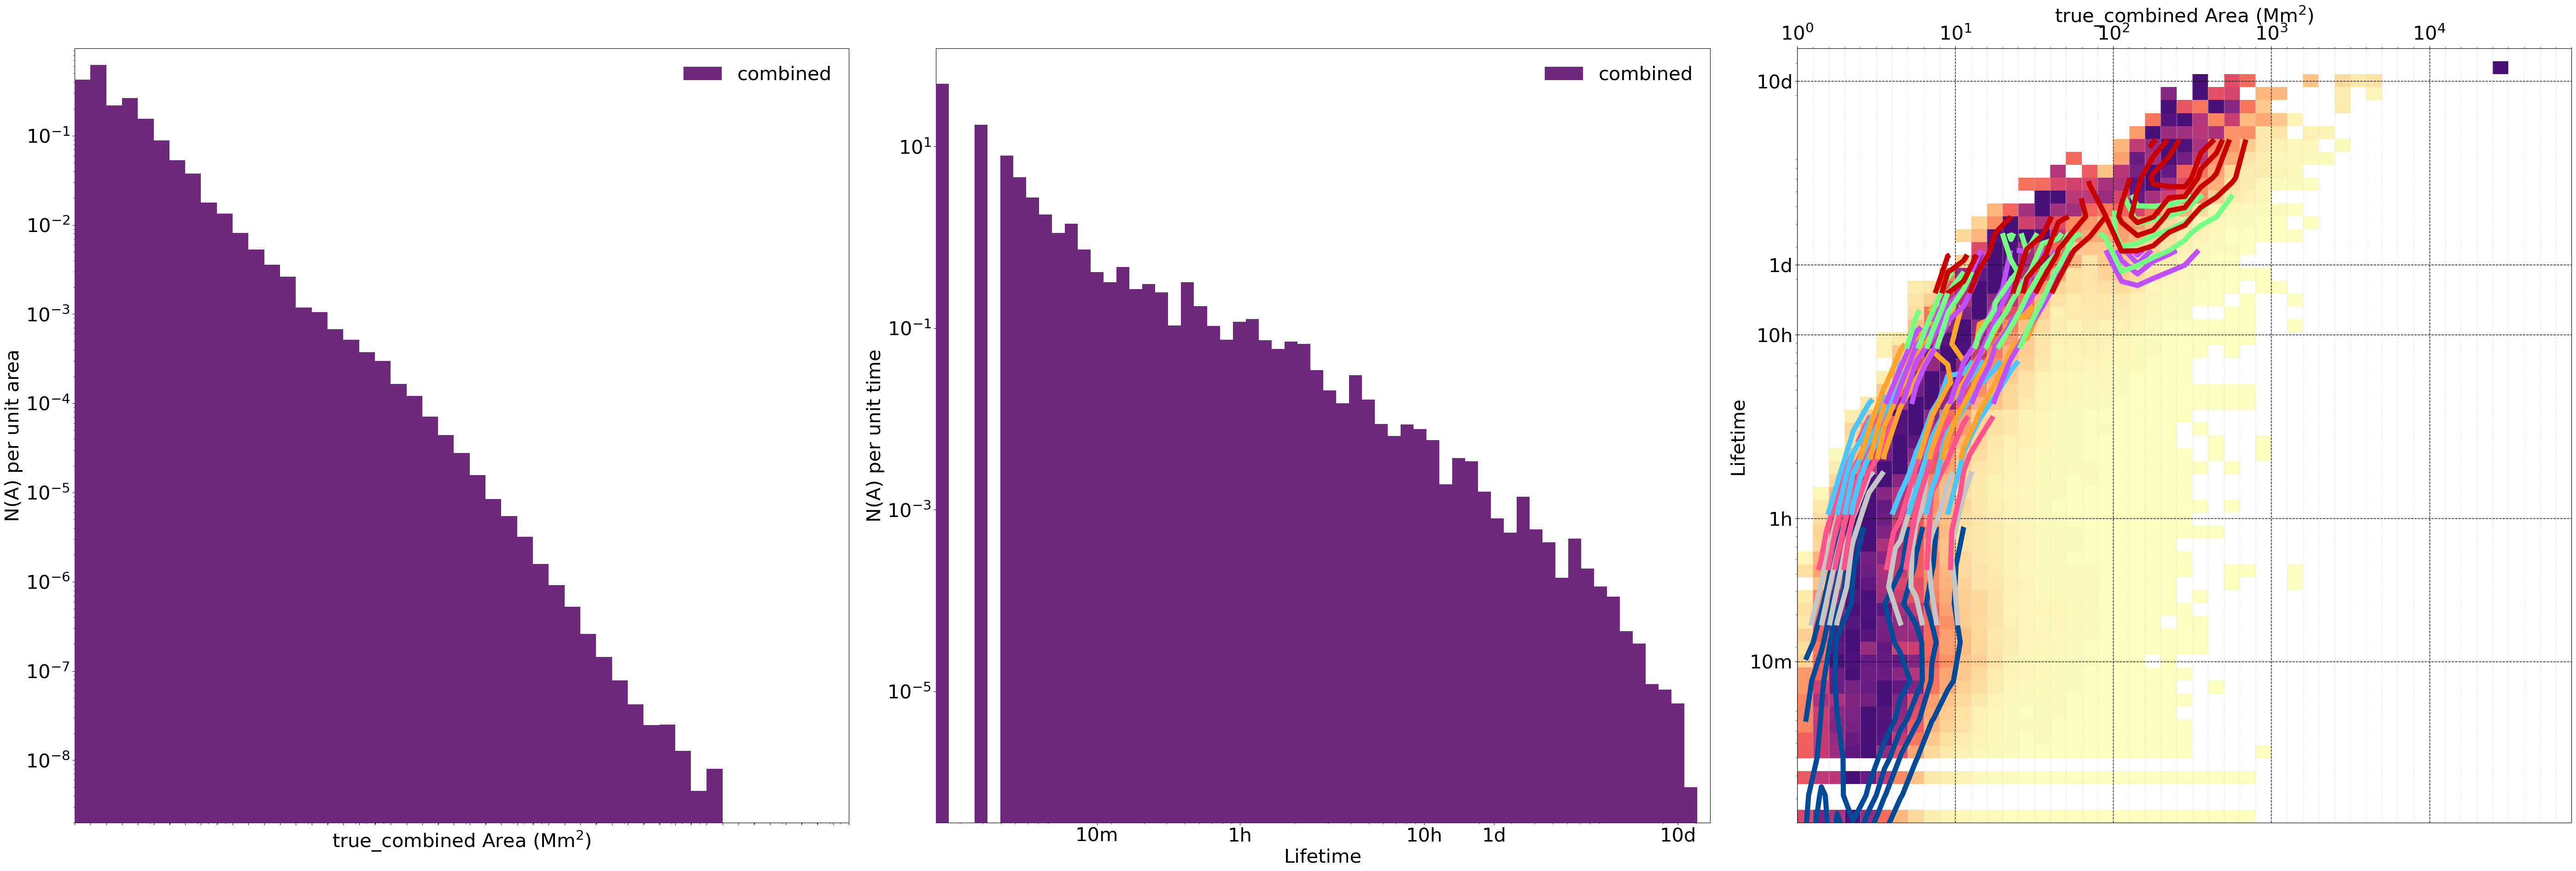

In [29]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

i=1

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (8*ppxx + 7*ppadh2 - ppadh3*2)/3



## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax3 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
 


ax1.hist(true_combined['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 8-i)
ax2.hist(true_combined['Life'], bins = edgesT_comb, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder=8-i)



ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

ax1.set_xticks(edgesA, minor=False)
ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('true_combined Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = T1, right = T2);

ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax2.set_xlabel('Lifetime');
ax2.set_ylabel('N(A) per unit time')




histout = np.histogram2d(true_combined['Area'], true_combined['Life'], bins = [edgesA,edgesT_comb])




widthsA_combt = edgesA[1:]-edgesA[0:-1]
hst_nrmA_combt = (histout[0]/widthsA_combt[:,None])/histout[0].sum(0)[None,:]

hst_nrmA_combt[histout[0]<=2] = np.nan
hst_nrmA_combt = hst_nrmA_combt.T

hst_nrmA_clrN_combt = hst_nrmA_combt/np.nanmax(hst_nrmA_combt,axis=1)[:,None]
hst_nrmA_clrN_combt = hst_nrmA_clrN_combt.copy()




# ax3.pcolormesh(edgesA, edgesT_comb, hist_normA, cmap=plt.cm.magma_r)
ax3.pcolormesh(edgesA, edgesT_comb, hst_nrmA_clrN_combt, cmap=plt.cm.magma_r, vmax=1.3)
# ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(bottom = T1, top = T2);
ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax3.set_xlabel('true_combined Area (Mm$^2$)')


for i in range(8):
    time = 45*2**i

    ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (features[time]['edgesT'][0:-1]+features[time]['edgesT'][1:])/2, features[time]['hst_nrmA_clrN'], np.linspace(0,1,6), colors=Clr[i], linewidths=8)

ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax3.xaxis.tick_top()
ax3.minorticks_on()
ax3.set_xticks(edgesA, minor=True)
ax3.set_xticklabels([], minor=True);
ax3.xaxis.set_label_position('top')

ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)
ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax3.set_ylabel('Lifetime')

# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position('right')

ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')


# fig.savefig('Area_lifetime_Combined.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

### Adjust for different times of observation

In [51]:
def AreaLifeJointDistributions(true_combined, edgesA, edgesT):
    '''
    Function to return the adjusted Area, Life, and 2D Area vs Life distributions by inflating the number of short lived objects
    in the true merge according to their origin

    Params:
        true_combined: pd.DataFrame
            Dataframe with true combined features that will be used to make the calculations            
        edgesA:  np.array
            Array with the area edges to use in the calculation
        edgesT:  np.array
            Array with the time edges to use in the calculation
    '''

    area_hist = np.zeros(edgesA.shape[0]-1)
    life_hist = np.zeros(edgesT.shape[0]-1)
    area_life_hist = np.zeros((edgesA.shape[0]-1, edgesT.shape[0]-1))

    for i in range(10):
        time = 45*2**i
        origin_subset = true_combined.loc[true_combined['Origin']==time,:].copy()

        # Area calculation
        histout = np.histogram(origin_subset['Area'], bins = edgesA)
        area_hist = area_hist + histout[0]*np.max(true_combined['Origin'])/time

        # Lifetime calculation
        histout = np.histogram(origin_subset['Life'], bins = edgesT)
        life_hist = life_hist + histout[0]*np.max(true_combined['Origin'])/time
        
        # Area Lifetime calculation

        histout = np.histogram2d(origin_subset['Area'], origin_subset['Life'], bins = [edgesA,edgesT])
        area_life_hist = area_life_hist + histout[0]*np.max(true_combined['Origin'])/time      

    # Convert non-uniform histograms into distributions

    # Define widths    
    widthsA = edgesA[1:]-edgesA[0:-1]
    widthsT = edgesT[1:]-edgesT[0:-1]

    # Area
    area_dis = area_hist/widthsA/area_hist.sum(0)

    # Life
    life_dis = life_hist/widthsT/life_hist.sum(0)

    # Area and Life    
    area_life_dis1D = (area_life_hist/widthsA[:,None])/area_life_hist.sum(0)[None,:]
    area_life_dis1D[area_life_hist<=2] = np.nan
    area_life_dis1D = area_life_dis1D.T

    area_life_dis1DN = area_life_dis1D/np.nanmax(area_life_dis1D,axis=1)[:,None]
    area_life_dis1DN = area_life_dis1DN.copy()

    return area_dis, life_dis, area_life_dis1D, area_life_dis1DN

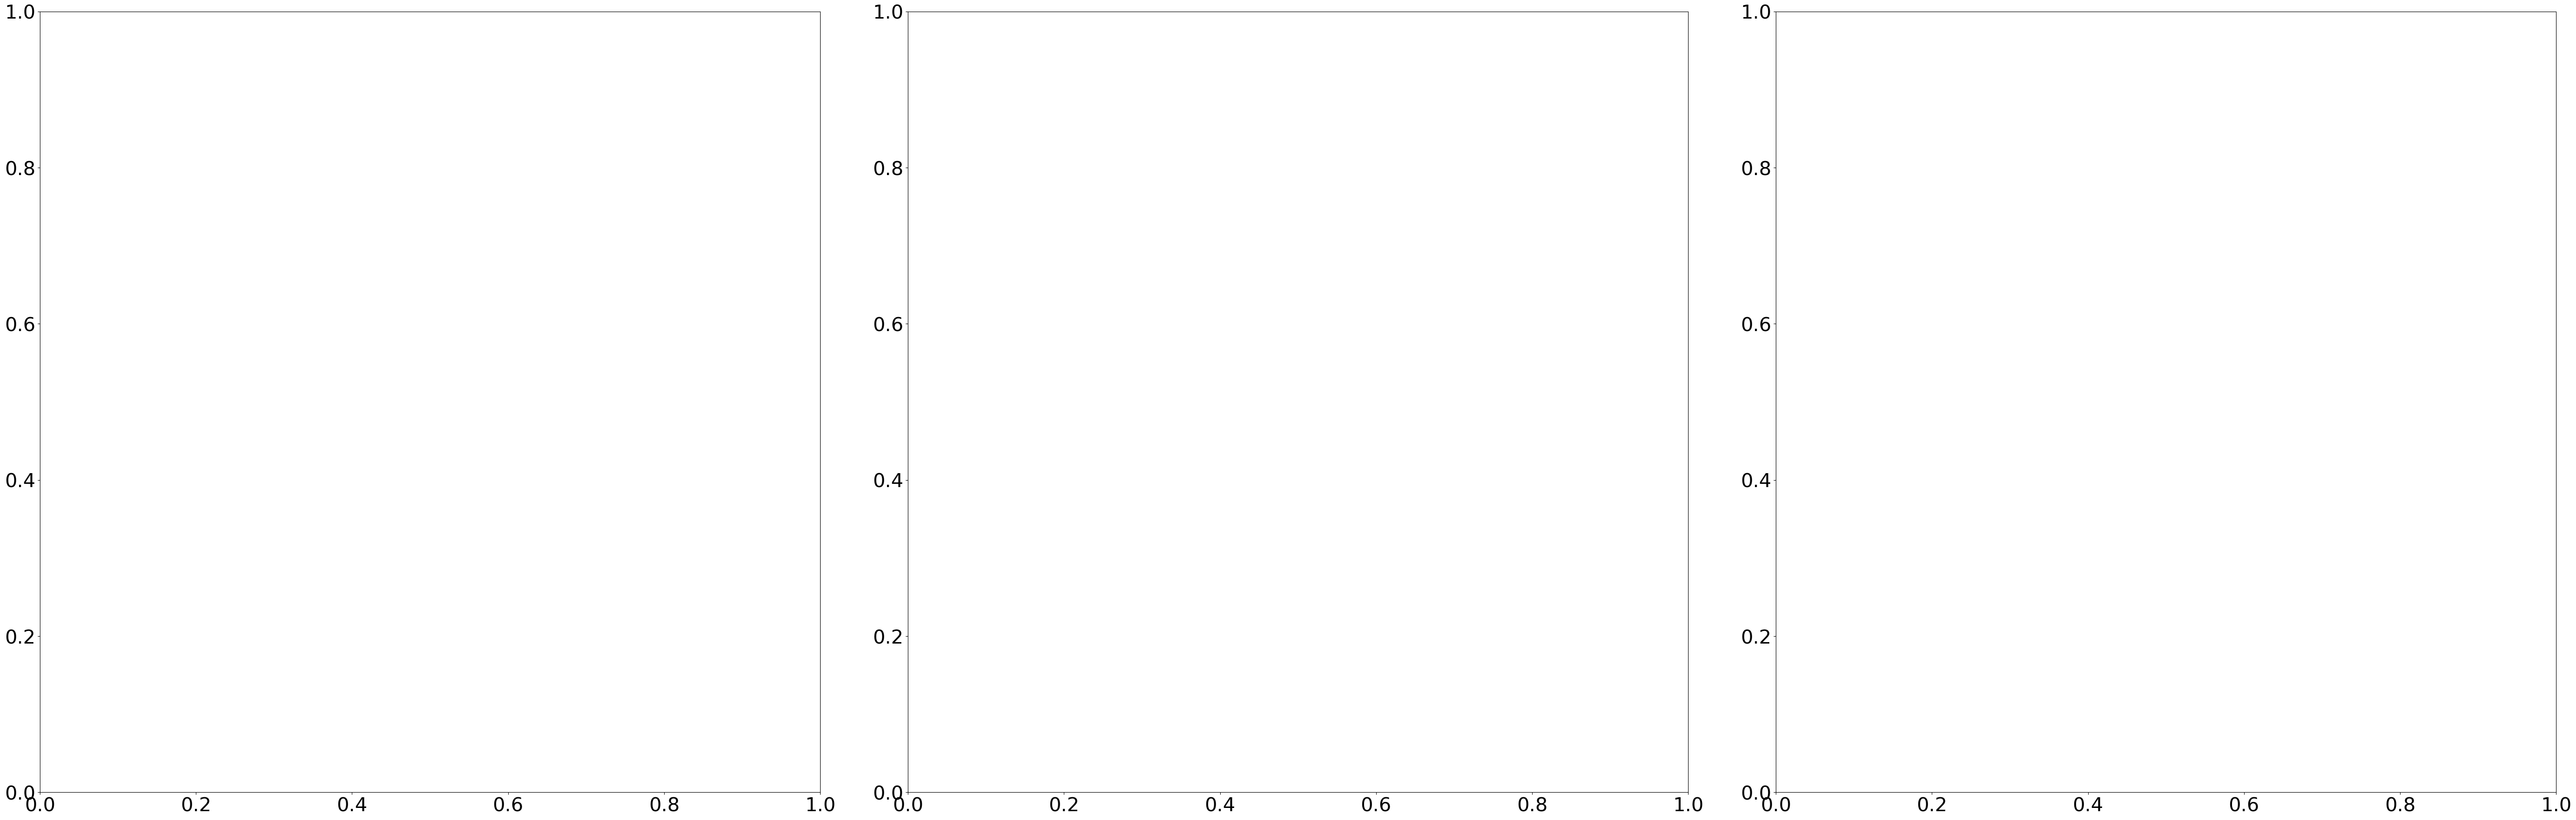

In [33]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

i=1

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (8*ppxx + 7*ppadh2 - ppadh3*2)/3


# Define widths    
widthsA = edgesA[1:]-edgesA[0:-1]
widthsT = edgesT_comb[1:]-edgesT_comb[0:-1]
area_dis, life_dis, area_life_dis1D, area_life_dis1DN = AreaLifeJointDistributions(true_combined, edgesA, edgesT_comb)


## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax1.bar(edgesA[0:-1], area_dis, widthsA, align='edge')



ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax3 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
 


# ax1.hist(true_combined['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 8-i)
# ax2.hist(true_combined['Life'], bins = edgesT_comb, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder=8-i)



# ax1.legend(frameon=False)

# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

# ax1.set_ylim(bottom = 2e-9, top = 0.95)
# ax1.set_ylabel('N(A) per unit area')

# ax1.set_xticks(edgesA, minor=False)
# ax1.set_xticklabels([], minor=False)
# ax1.set_xlabel('true_combined Area (Mm$^2$)');


# ax2.legend(frameon=False)

# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xlim(left = T1, right = T2);

# ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
# ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
# ax2.set_xlabel('Lifetime');
# ax2.set_ylabel('N(A) per unit time')




# histout = np.histogram2d(true_combined['Area'], true_combined['Life'], bins = [edgesA,edgesT_comb])




# widthsA_combt = edgesA[1:]-edgesA[0:-1]
# hst_nrmA_combt = (histout[0]/widthsA_combt[:,None])/histout[0].sum(0)[None,:]

# hst_nrmA_combt[histout[0]<=2] = np.nan
# hst_nrmA_combt = hst_nrmA_combt.T

# hst_nrmA_clrN_combt = hst_nrmA_combt/np.nanmax(hst_nrmA_combt,axis=1)[:,None]
# hst_nrmA_clrN_combt = hst_nrmA_clrN_combt.copy()




# # ax3.pcolormesh(edgesA, edgesT_comb, hist_normA, cmap=plt.cm.magma_r)
# ax3.pcolormesh(edgesA, edgesT_comb, hst_nrmA_clrN_combt, cmap=plt.cm.magma_r, vmax=1.3)
# # ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

# ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax3.set_ylim(bottom = T1, top = T2);
# ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# # ax3.set_xticklabels([])

# ax3.set_xlabel('true_combined Area (Mm$^2$)')


# for i in range(8):
#     time = 45*2**i

#     ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (features[time]['edgesT'][0:-1]+features[time]['edgesT'][1:])/2, features[time]['hst_nrmA_clrN'], np.linspace(0,1,6), colors=Clr[i], linewidths=8)

# ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
# ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
# ax3.xaxis.tick_top()
# ax3.minorticks_on()
# ax3.set_xticks(edgesA, minor=True)
# ax3.set_xticklabels([], minor=True);
# ax3.xaxis.set_label_position('top')

# ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)
# ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
# ax3.set_ylabel('Lifetime')

# # ax3.yaxis.tick_right()
# # ax3.yaxis.set_label_position('right')

# ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
# ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')


# fig.savefig('Area_lifetime_Combined.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## Read MDI


In [11]:
FeatureMDI = pd.read_pickle('data/SWAMIS/MDI_Features.pnds')

CDELT1 = (1.977283+1.986302)/2
# CDELT1 = 0.504223
Rs = 968.580444
Rsun = 696000000
DOBS = 148217766833.31

# Converting flux to maxwells
FeatureMDI['Flux'] = FeatureMDI['Flux']*(CDELT1*FeatureMDI['scale'])**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2*FeatureMDI['scale']/1.3
# FeatureMDI['Flux'] = FeatureMDI['Flux']*(CDELT1)**2/(np.pi*Rs**2)*2*np.pi*(Rsun*100)**2



# Add distance from disk center in arcseconds
FeatureMDI['Dis'] = np.sqrt(FeatureMDI['xs']**2+FeatureMDI['ys']**2)
FeatureMDI['Ang'] = -(FeatureMDI['Dis']/60/60*np.pi/180- np.arcsin(np.sin(FeatureMDI['Dis']/60/60*np.pi/180)*DOBS/Rsun))

FeatureMDI['Area'] = 2*np.pi*(Rsun/1000000)**2*FeatureMDI['size_s']/(np.pi*Rs**2)*np.divide(1,np.cos(FeatureMDI['Ang']))
FeatureMDI['meanB'] = np.divide(np.abs(FeatureMDI['Flux']),FeatureMDI['Area']*100000000**2)


FeatureMDI = FeatureMDI.loc[FeatureMDI['Life']<np.nanmax(FeatureMDI['Life']), :]

# if i>0:
#     FeatureMDI = FeatureMDI.loc[FeatureMDI['Life']>life_cut, :]

FeatureMDI['Life'] = FeatureMDI['Life']*96/60

In [12]:
np.nanmin(FeatureMDI['Life'])

1.6

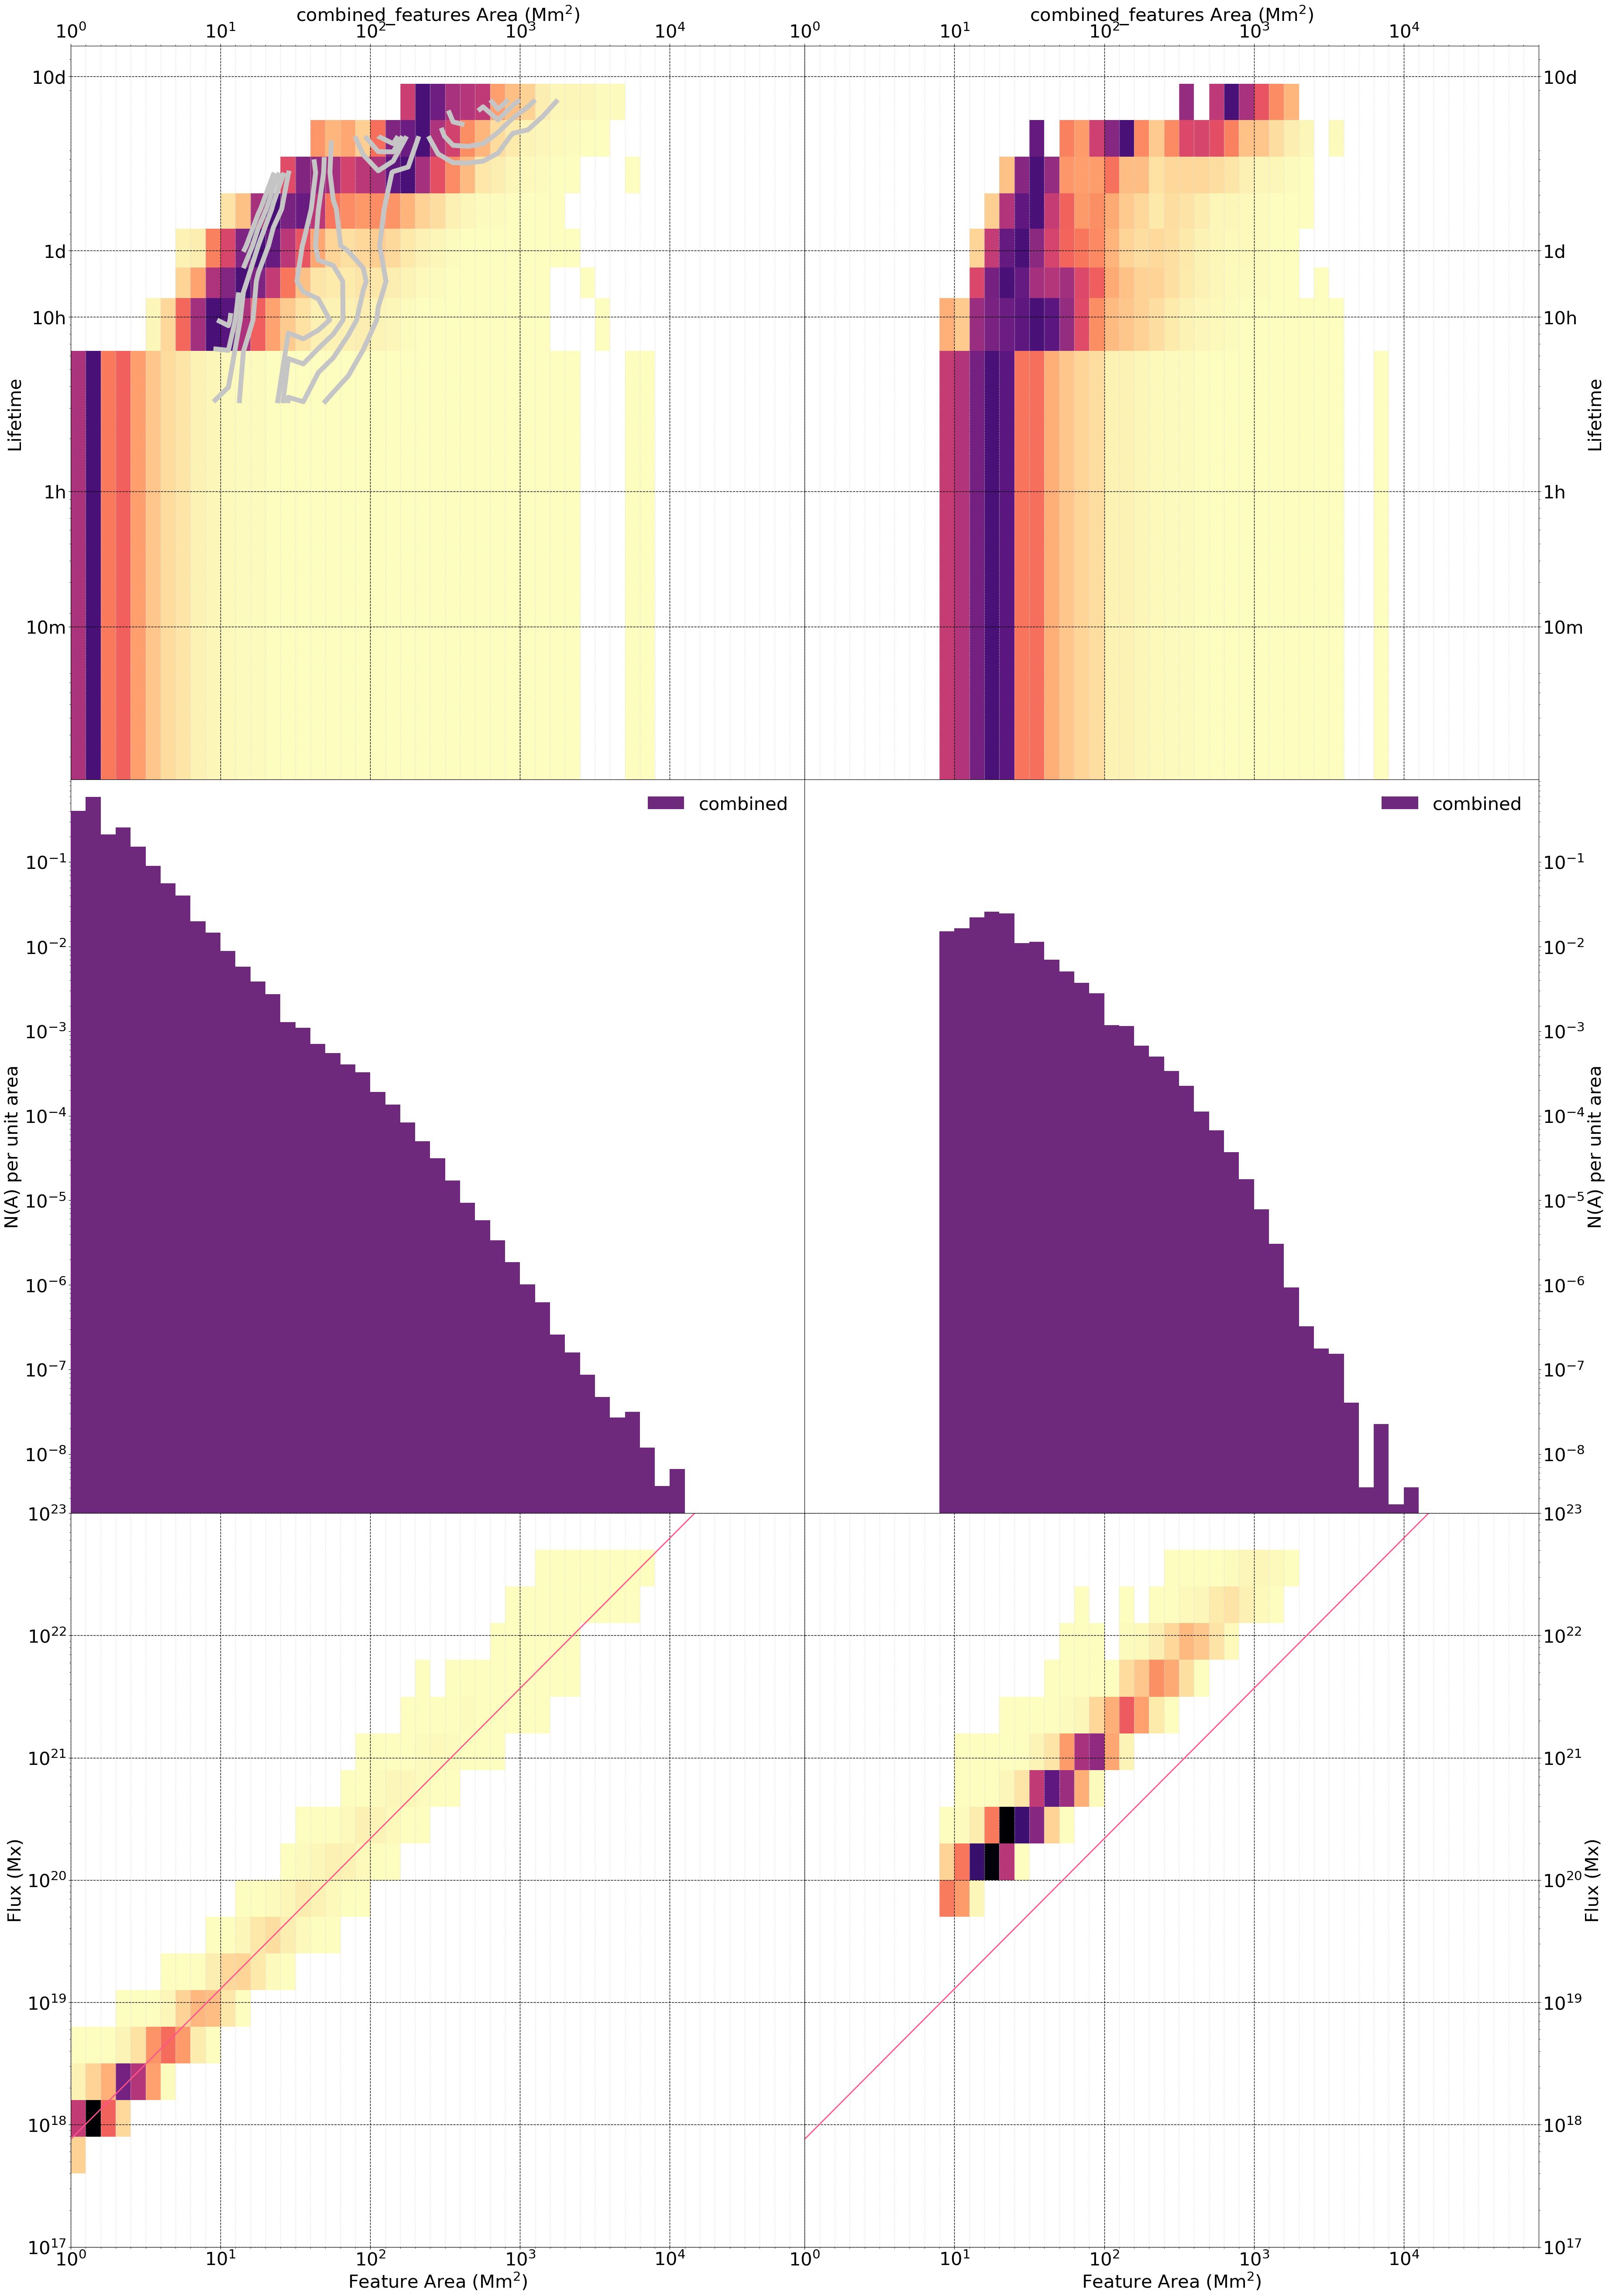

In [13]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

i=1

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (8*ppxx + 7*ppadh2 - ppadh3*2)/3




## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
ax3 = fig.add_axes([ppadh, ppadv - ppadv2, ppxx2, ppxx2*fszh/fszv])
ax5 = fig.add_axes([ppadh, ppadv - ppadv2 - 2*ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
 

ax2 = fig.add_axes([ppadh+ppxx2, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])
ax4 = fig.add_axes([ppadh+ppxx2, ppadv - ppadv2, ppxx2, ppxx2*fszh/fszv])
ax6 = fig.add_axes([ppadh+ppxx2, ppadv - ppadv2 - 2*ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])



ax1.hist(combined_features['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 8-i)
ax2.hist(FeatureMDI['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 8-i)


ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

ax1.set_xticks(edgesA, minor=False)
ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('combined_features Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax2.set_ylim(bottom = 2e-9, top = 0.95)
ax2.set_ylabel('N(A) per unit area')

ax2.set_xticks(edgesA, minor=False)
ax2.set_xticklabels([], minor=False)
ax2.set_xlabel('combined_features Area (Mm$^2$)');

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')


histout = np.histogram2d(FeatureMDI['Area'], FeatureMDI['Life'], bins = [edgesA,edgesT])


# widthsT = edgesT[1:]-edgesT[0:-1]
# hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


widthsA = edgesA[1:]-edgesA[0:-1]
hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

hst_nrmA[histout[0]<=2] = np.nan
hst_nrmA = hst_nrmA.T

hst_nrmA_clrN_MDI = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]

# ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
ax4.pcolormesh(edgesA, edgesT, hst_nrmA_clrN_MDI, cmap=plt.cm.magma_r, vmax=1.3)
# ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim(bottom = T1, top = T2);
ax4.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax4.set_xlabel('combined_features Area (Mm$^2$)')


# for i in range(8):
#     time = 45*2**i

#     ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (edgesT[0:-1]+edgesT[1:])/2, features[time]['hst_nrmA_clrN'], np.linspace(0,1,6), colors=Clr[i], linewidths=8)

ax4.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax4.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax4.xaxis.tick_top()
ax4.minorticks_on()
ax4.set_xticks(edgesA, minor=True)
ax4.set_xticklabels([], minor=True);
ax4.xaxis.set_label_position('top')

ax4.set_yticks([10/60, 1, 10, 24, 240], minor=False)
ax4.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax4.set_ylabel('Lifetime')

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')

ax4.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax4.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')






histout = np.histogram2d(combined_features['Area'], combined_features['Life'], bins = [edgesA,edgesT])


# widthsT = edgesT[1:]-edgesT[0:-1]
# hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


widthsA = edgesA[1:]-edgesA[0:-1]
hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

hst_nrmA[histout[0]<=2] = np.nan
hst_nrmA = hst_nrmA.T

hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]

# ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
ax3.pcolormesh(edgesA, edgesT, hst_nrmA_clrN, cmap=plt.cm.magma_r, vmax=1.3)
# ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)


ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (edgesT[0:-1]+edgesT[1:])/2, hst_nrmA_clrN_MDI, np.linspace(0,1,6), colors=Clr[i], linewidths=8)



ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(bottom = T1, top = T2);
ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax3.set_xlabel('combined_features Area (Mm$^2$)')


# for i in range(8):
#     time = 45*2**i

#     ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (edgesT[0:-1]+edgesT[1:])/2, features[time]['hst_nrmA_clrN'], np.linspace(0,1,6), colors=Clr[i], linewidths=8)

ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax3.xaxis.tick_top()
ax3.minorticks_on()
ax3.set_xticks(edgesA, minor=True)
ax3.set_xticklabels([], minor=True);
ax3.xaxis.set_label_position('top')

ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)
ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax3.set_ylabel('Lifetime')

# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position('right')

ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')






###############################################################################################
# Flux density vs Area
###############################################################################################
clr='k'

Nbins = 20

B1 = 1e17
B2 = 1e23
edgesB = np.power(10,np.arange(np.log10(B1),np.log10(B2),(np.log10(B2)-np.log10(B1))/Nbins))


# Scatter Plot
ax5.hist2d(combined_features['Area'], np.abs(combined_features['Flux']), bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)

# def fit_func(x, a, b):
#     return a*np.power(x,b)

def fit_func(x, a, b):
    return a+x*b

params = curve_fit(fit_func, np.log10(combined_features['Area'].values.astype(float)), np.log10(np.abs(combined_features['Flux']).values.astype(float)))
# params = curve_fit(fit_func, combined_features['Area'].values.astype(float), np.abs(combined_features['Flux']).values.astype(float))
[a, b] = params[0]
# ax5.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)
ax5.plot(edgesA, np.power(10, fit_func(np.log10(edgesA), a, b)), lw=2, color=Clr[2], alpha=1)


# ax5.fill_between(edgesA, np.power(10, fit_func(np.log10(edgesA), a, b))/1.5, np.power(10, fit_func(np.log10(edgesA), a, b))*1.5, color='k', alpha=0.2, zorder = 0)
        
# ypos1 = -0.18
# ypos2 = -0.245

# xpos1 = 0 
# xpos2 = 0.05

# totshift = -0.1

# shift = 0.49 + totshift
# ax5.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

# shift = 0.81 + totshift
# ax5.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_ylim(bottom = B1, top = B2);
ax5.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax5.set_xlabel('Feature Area (Mm$^2$)')
ax5.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax5.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax5.minorticks_on()
ax5.set_xticks(edgesA, minor=True)
ax5.set_xticklabels([], minor=True);

# ax5.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
# ax5.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
ax5.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

ax5.set_ylabel('Flux (Mx)')















# Scatter Plot
ax6.hist2d(FeatureMDI['Area'], np.abs(FeatureMDI['Flux']), bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)
# ax6.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)

ax6.plot(edgesA, np.power(10, fit_func(np.log10(edgesA), a, b)), lw=2, color=Clr[2], alpha=1)


ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_ylim(bottom = B1, top = B2);
ax6.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax6.set_xlabel('Feature Area (Mm$^2$)')
ax6.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax6.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax6.minorticks_on()
ax6.set_xticks(edgesA, minor=True)
ax6.set_xticklabels([], minor=True);

# ax6.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
# ax6.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
ax6.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

ax6.set_ylabel('Flux (Mx)')

ax6.yaxis.tick_right()
ax6.yaxis.set_label_position('right')




# fig.savefig('HMI_MDI.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## Make dictionary with Bard runs reading keeping negative and positive regions separately

In [14]:
instruments = ['KPVT', 'SPMG', 'MDI', 'HMI']
featuresBARD = {}
for i,instrument in enumerate(instruments):
   FeatureP = pd.read_pickle(f'data/BARD/bard_{instrument}.pnds').loc[:,['MDI day', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'P Flux',
      'P Area', 'P Latitude', 'P Longitude', 'P Avg. Radius', 'Life', 'date']]
   FeatureP = FeatureP.rename(columns={'P Flux': 'Flux','P Area': 'Area', 'P Latitude': 'Latitude', 'P Longitude': 'Longitude', 'P Avg. Radius':'Avg. Radius'})
   FeatureN = pd.read_pickle(f'data/BARD/bard_{instrument}.pnds').loc[:,['MDI day', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'N Flux',
      'N Area', 'N Latitude', 'N Longitude', 'N Avg. Radius', 'Life', 'date']]
   FeatureN = FeatureN.rename(columns={'N Flux': 'Flux','N Area': 'Area', 'N Latitude': 'Latitude', 'N Longitude': 'Longitude', 'N Avg. Radius':'Avg. Radius'})

   Feature = pd.concat((FeatureP, FeatureP)).reset_index(drop=True)
   Feature['Life'] = Feature['Life']*24
   Feature['Area'] = Feature['Area']/1000000/1000000/100/100

   # if instrument=='HMI':
   #    mask = np.logical_and(Feature['date']>=pd.to_datetime('2014-04-27'), Feature['date']<=pd.to_datetime('2014-05-07'))
   #    Feature = Feature.loc[mask,:]

   featuresBARD[instrument] = {}
   featuresBARD[instrument]['features'] = Feature


In [15]:
Feature['date']

0      2010-04-26
1      2010-05-02
2      2010-05-03
3      2010-05-04
4      2010-05-04
          ...    
2907   2016-06-16
2908   2016-06-18
2909   2016-06-20
2910   2016-06-29
2911   2016-07-04
Name: date, Length: 2912, dtype: datetime64[ns]

In [16]:
pd.read_pickle(f'data/BARD/bard_{instrument}.pnds').columns

Index(['MDI day', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'P Flux',
       'P Area', 'P Latitude', 'P Longitude', 'P Avg. Radius', 'N Flux',
       'N Area', 'N Latitude', 'N Longitude', 'N Avg. Radius', 'Plrt Dis.',
       'Tilt', 'Ldng Plrt', 'DM', 'QM', 'Abs Flux', 'Tot Area', 'Life',
       'date'],
      dtype='object')

## Fit BARD Areas to SWAMIS HMI

In [17]:
factors = np.arange(1,20,0.05)

for i,instrument in enumerate(instruments):
    maximum_likelihood = factors*0
    for j, factor in enumerate(factors):
        Feature = featuresBARD[instrument]['features']
        histout = np.histogram2d(Feature['Area']/factor, Feature['Life'], bins = [edgesA,edgesT_comb])
        maximum_likelihood[j] = np.nansum(np.log(hst_nrmA_comb.astype(float))*histout[0].T.astype(float))
    featuresBARD[instrument]['calibration'] = 1/factors[(maximum_likelihood==np.nanmin(maximum_likelihood)).nonzero()[0]]
    print(f'{instrument} calibration: {featuresBARD[instrument]["calibration"]}')



KPVT calibration: [0.23529412]
SPMG calibration: [0.35714286]
MDI calibration: [0.29411765]
HMI calibration: [0.57142857]


## Fit BARD Fluxes to SWAMIS HMI

In [18]:
flux_area_dist = np.histogram2d(combined_features['Area'], np.abs(combined_features['Flux']), bins = [edgesA,edgesB], density=True)
flux_area_dist = flux_area_dist[0]+np.nanmin(flux_area_dist[0][flux_area_dist[0]>0])/1000

factors = np.arange(0,1,0.001)

for i,instrument in enumerate(instruments):
    maximum_likelihood = factors*0
    for j, factor in enumerate(factors):
        Feature = featuresBARD[instrument]['features']
        histout = np.histogram2d(Feature['Area']*featuresBARD[instrument]['calibration'], np.abs(Feature['Flux'])*factor, bins = [edgesA,edgesB])
        maximum_likelihood[j] = np.nansum(np.log(np.abs(flux_area_dist).astype(float))*histout[0])
    featuresBARD[instrument]['flux_calibration'] = factors[(maximum_likelihood==np.nanmin(maximum_likelihood)).nonzero()[0]]
    print(f'{instrument} flux calibration: {featuresBARD[instrument]["flux_calibration"]}')

KPVT flux calibration: [0.001 0.002 0.003 0.004 0.005 0.006 0.008 0.009 0.011 0.012 0.013 0.014
 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024]
SPMG flux calibration: [0.001 0.002 0.003 0.004 0.006 0.007 0.009 0.01  0.012 0.014 0.016 0.018
 0.02  0.024 0.025 0.026 0.029]
MDI flux calibration: [0.013 0.024]
HMI flux calibration: [0.01]


336.0
hst_nrmA_clrN 0.000970703606892604 1.0
max life for KPVT 336.0
calibrated max area for KPVT 6894.11764705882
264.0
hst_nrmA_clrN 0.007629850980570736 1.0


C:\Users\Andres\AppData\Local\Temp\ipykernel_337256\1601744862.py:80: RuntimeWarning: invalid value encountered in divide
  hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_337256\1601744862.py:85: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


max life for SPMG 264.0
calibrated max area for SPMG 4392.85714285714
29592.0
hst_nrmA_clrN 0.00270912018176904 1.0
max life for MDI 29592.0
calibrated max area for MDI 6941.1764705882315
264.0
hst_nrmA_clrN 0.0026603497532918397 1.0
max life for HMI 264.0
calibrated max area for HMI 13714.285714285708


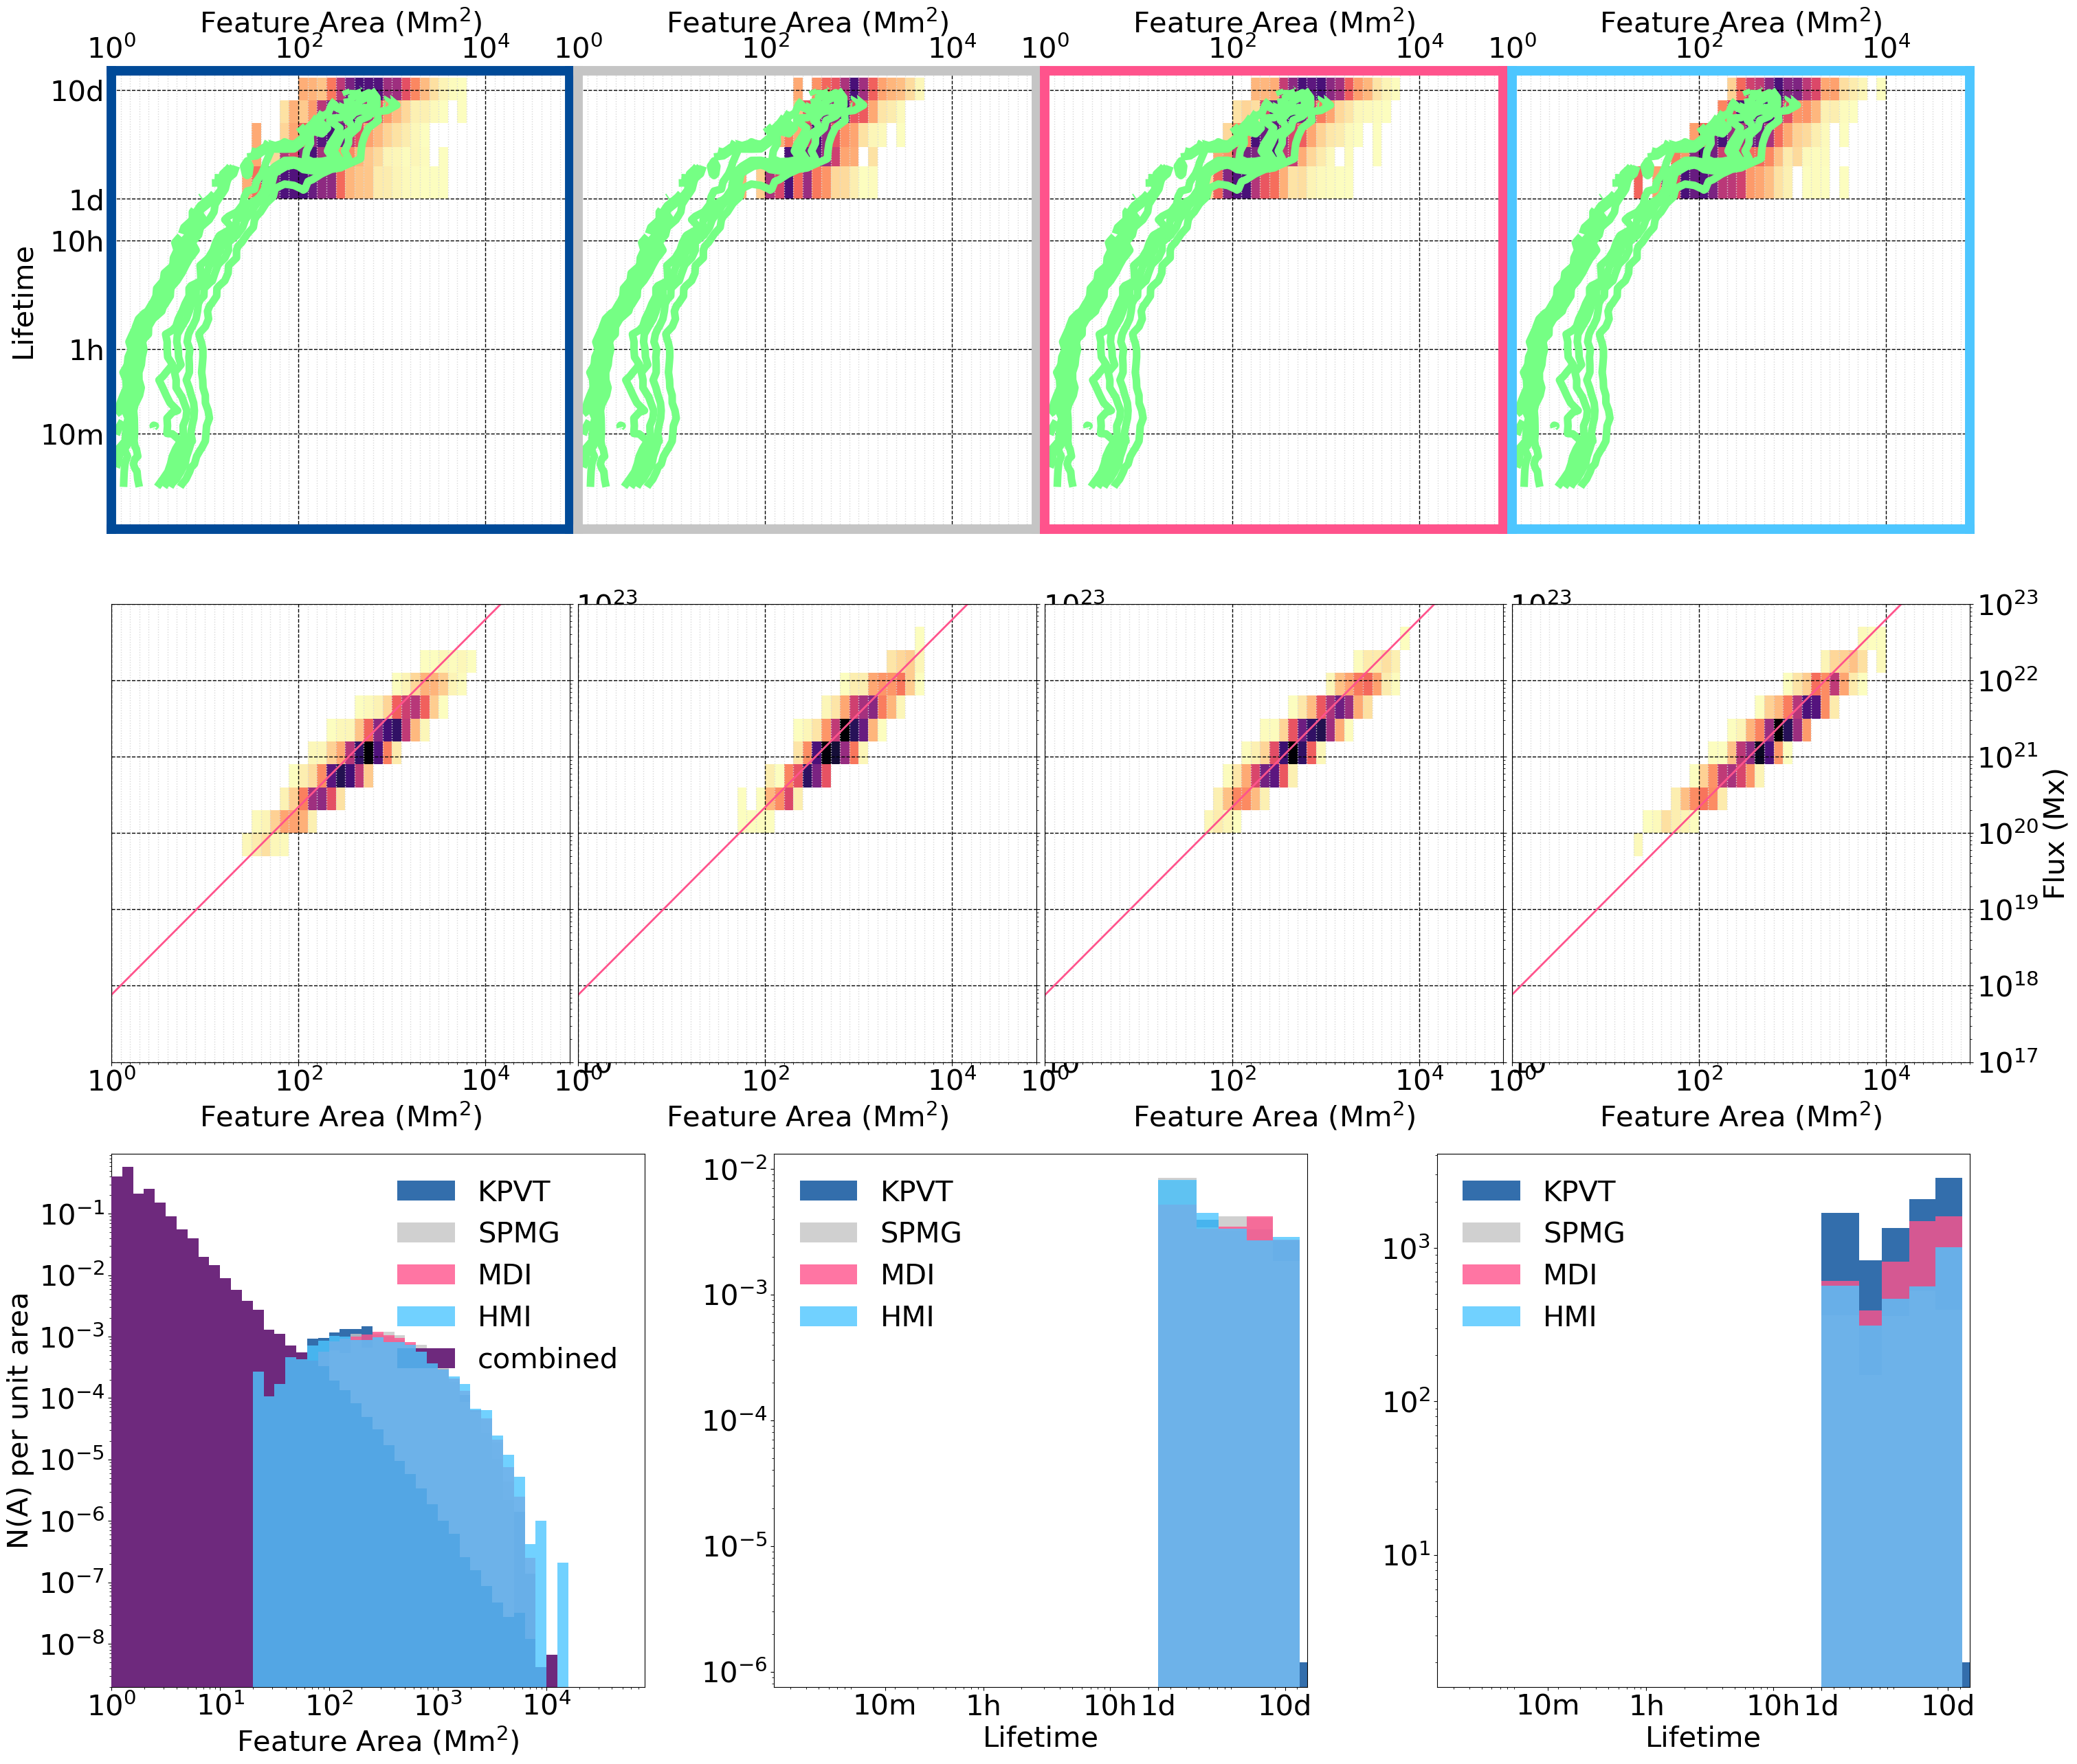

In [19]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (4*ppxx + 3*ppadh2 - ppadh3*2)/3




## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - 2*ppadv2 - 2*ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - 2*ppadv2 - 2*ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax4 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - 2*ppadv2 - 2*ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])


edgesTB = Fibonacci*24

for i,instrument in enumerate(instruments):

    Feature = featuresBARD[instrument]['features']
    calibration = featuresBARD[instrument]["calibration"]

    # Scatter Plot
    ax3 = fig.add_axes([ppadh+(ppxx+ppadh2)*i, ppadv, ppxx, ppxy])

    histout = np.histogram2d(Feature['Area']*calibration, Feature['Life'], bins = [edgesA,edgesTB])

    print(np.nanmax(Feature['Life']))



    widthsA = edgesA[1:]-edgesA[0:-1]
    hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

    hst_nrmA[histout[0]<=2] = np.nan
    hst_nrmA = hst_nrmA.T

    hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


    #--------
    # Storing matrices
    features[time]['hst'] = histout[0].T
    features[time]['hst_nrmA'] = hst_nrmA
    features[time]['hst_nrmA_clrN'] = hst_nrmA_clrN

    print('hst_nrmA_clrN', np.nanmin(hst_nrmA_clrN), np.nanmax(hst_nrmA_clrN))
    


    # ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
    ax3.pcolormesh(edgesA, edgesTB, hst_nrmA_clrN, cmap=plt.cm.magma_r, vmax=1.3)
    # ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

    ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (edgesT_comb[0:-1]+edgesT_comb[1:])/2, hst_nrmA_clrN_comb, np.linspace(0,1,6), colors=Clr[6], linewidths=8)

    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(bottom = T1, top = T2);
    ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
    # ax3.set_xticklabels([])

    ax3.set_xlabel('Feature Area (Mm$^2$)')



    ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax3.xaxis.tick_top()
    ax3.minorticks_on()
    ax3.set_xticks(edgesA, minor=True)
    ax3.set_xticklabels([], minor=True);
    ax3.xaxis.set_label_position('top')

    ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)


    if i==0 or i==7:
        ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
        ax3.set_ylabel('Lifetime')
    else:
        ax3.set_yticklabels(['', '', '', '', ''] , minor=False)

    if i==7:
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position('right')

    ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    plt.setp(ax3.spines.values(), color=Clr[i], linewidth=10)        

    # if instrument == 'HMI':
    ax1.hist(Feature['Area']*calibration, bins = edgesA, color=Clr[i], alpha=0.8, density = True, label=f'{instrument}', zorder = 2*i+1)
    ax2.hist(Feature['Life'], bins = edgesTB, color=Clr[i], alpha=0.8, density = True, label=f'{instrument}', zorder= 2*i+1)
    ax4.hist(Feature['Life'], bins = edgesTB, color=Clr[i], alpha=0.8, density = False, label=f'{instrument}', zorder= 2*i+1 )
    print(f'max life for {instrument}', np.nanmax(Feature['Life']))
    print(f'calibrated max area for {instrument}', np.nanmax(Feature['Area']*calibration))


    ax5 = fig.add_axes([ppadh+(ppxx+ppadh2)*i, ppadv - ppxx2*fszh/fszv, ppxx, ppxy])
    ax5.hist2d(Feature['Area']*calibration, np.abs(Feature['Flux'])*calibration, bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)

    ax5.plot(edgesA, np.power(10, fit_func(np.log10(edgesA), a, b)), lw=2, color=Clr[2], alpha=1)


    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.set_ylim(bottom = B1, top = B2);
    ax5.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax5.set_xlabel('Feature Area (Mm$^2$)')
    ax5.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax5.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax5.minorticks_on()
    ax5.set_xticks(edgesA, minor=True)
    ax5.set_xticklabels([], minor=True);

    # ax5.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
    # ax5.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
    ax5.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    ax5.set_ylabel('Flux (Mx)')

    ax5.yaxis.tick_right()
    ax5.yaxis.set_label_position('right')    



ax1.hist(combined_features['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 5)
ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

# ax1.set_xticks(edgesA, minor=False)
# ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('Feature Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = T1, right = T2);

ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax2.set_xlabel('Lifetime');



ax4.legend(frameon=False)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left = T1, right = T2);

ax4.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax4.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax4.set_xlabel('Lifetime');



# fig.savefig('Area_lifetime_RotAssoc.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## Load sunpot area measurements

In [20]:
sunspot_area = pd.read_csv('data/Sunspot Area/composite_sunspot_groups_single_objects.csv')
sunspot_area['lifetime'] = sunspot_area['lifetime']*24
sunspot_area['date'] = pd.to_datetime(dict(year=sunspot_area.year, month=sunspot_area.month, day=sunspot_area.day))
sunspot_area.keys()

Index(['fracYear', 'dayNumber', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'latitude', 'longitude', 'observedArea', 'OAUnc',
       'correctedArea', 'CAUnc', 'observedUmbralA', 'OUAUnc',
       'correctedUmbralA', 'CUAUnc', 'uniqueID', 'yearlyID', 'nSpots',
       'degressDiskC', 'lifetime', 'CycleN', 'survey',
       'hemisphericSmoothNum6m', 'HSN6mUnc', 'hemisphericSmoothNum12m',
       'HSN12mUnc', 'hemisphericSmoothNum24m', 'HSN24mUnc', 'date'],
      dtype='object')

In [21]:
sunspot_area = sunspot_area.loc[np.logical_and(sunspot_area['date']>=np.min(featuresBARD['HMI']['features']['date']), sunspot_area['date']<=np.max(featuresBARD['HMI']['features']['date'])),:]
sunspot_area

fracYear  dayNumber  year  month  day  hour  minute  second   
83980  2010.315068     734254  2010      4   26    12     0.0     0.0  \
83981  2010.317808     734255  2010      4   27    12     0.0     0.0   
83982  2010.320548     734256  2010      4   28    15    44.0    31.0   
83983  2010.323288     734257  2010      4   29    12     0.0     0.0   
83984  2010.326027     734258  2010      4   30    12     0.0     0.0   
...            ...        ...   ...    ...  ...   ...     ...     ...   
86789  2016.497268     736512  2016      7    1     4    58.0    47.0   
86790  2016.500000     736513  2016      7    2    12     0.0     0.0   
86791  2016.502732     736514  2016      7    3    12     0.0     0.0   
86792  2016.505464     736515  2016      7    4     4    58.0    47.0   
86793  2016.505464     736515  2016      7    4     4    58.0    47.0   

       latitude  longitude  ...  lifetime  CycleN  survey   
83980       NaN        NaN  ...       NaN     NaN     NaN  \
83981       NaN        NaN  ...       NaN     NaN     NaN   
83982     12.80     262.26  ...      24.0    24.0  1003.0   
83983       NaN        NaN  ...       NaN     NaN     NaN   
83984       NaN        NaN  ...       NaN     NaN     NaN   
...         ...        ...  ...       ...     ...     ...   
86789    -16.57     344.88  ...      24.0    24.0  1003.0   
86790       NaN        NaN  ...       NaN     NaN     NaN   
86791       NaN        NaN  ...       NaN     NaN     NaN   
86792      3.23      41.20  ...      24.0    24.0  1003.0   
86793     11.26     345.15  ...      24.0    24.0  1003.0   

       hemisphericSmoothNum6m  HSN6mUnc  hemisphericSmoothNum12m  HSN12mUnc   
83980                     NaN       NaN                      NaN        NaN  \
83981                     NaN       NaN                      NaN        NaN   
83982                     NaN       NaN                      NaN        NaN   
83983                     NaN       NaN                      NaN        NaN   
83984                     NaN       NaN                      NaN        NaN   
...                       ...       ...                      ...        ...   
86789                     NaN       NaN                      NaN        NaN   
86790                     NaN       NaN                      NaN        NaN   
86791                     NaN       NaN                      NaN        NaN   
86792                     NaN       NaN                      NaN        NaN   
86793                     NaN       NaN                      NaN        NaN   

       hemisphericSmoothNum24m  HSN24mUnc       date  
83980                      NaN        NaN 2010-04-26  
83981                      NaN        NaN 2010-04-27  
83982                      NaN        NaN 2010-04-28  
83983                      NaN        NaN 2010-04-29  
83984                      NaN        NaN 2010-04-30  
...                        ...        ...        ...  
86789                      NaN        NaN 2016-07-01  
86790                      NaN        NaN 2016-07-02  
86791                      NaN        NaN 2016-07-03  
86792                      NaN        NaN 2016-07-04  
86793                      NaN        NaN 2016-07-04  

[2814 rows x 32 columns]

## Fit sunspot areas to SWAMIS HMI

In [22]:
factors = np.arange(1,30,0.01)
maximum_likelihood = factors*0

for j, factor in enumerate(factors):
    histout = np.histogram2d(sunspot_area['correctedArea']*factor, sunspot_area['lifetime'], bins = [edgesA,edgesT_comb])
    maximum_likelihood[j] = np.nansum(np.log(hst_nrmA_comb.astype(float))*histout[0].T.astype(float))
print(maximum_likelihood)
sunspot_area_calibration = factors[(maximum_likelihood==np.nanmin(maximum_likelihood)).nonzero()[0]]
print(f'Sunspot Area calibration: {sunspot_area_calibration}')

[-3234.5547511  -3287.64507365 -3339.81501757 ... -7194.50205417
 -7195.29192847 -7195.29192847]
Sunspot Area calibration: [9.76]


384.0
hst_nrmA_clrN 0.0043121968093205254 1.0
max life for HMI 384.0
calibrated max area for HMI 42208.03181485537


C:\Users\Andres\AppData\Local\Temp\ipykernel_337256\2022609057.py:80: RuntimeWarning: invalid value encountered in divide
  hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_337256\2022609057.py:85: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


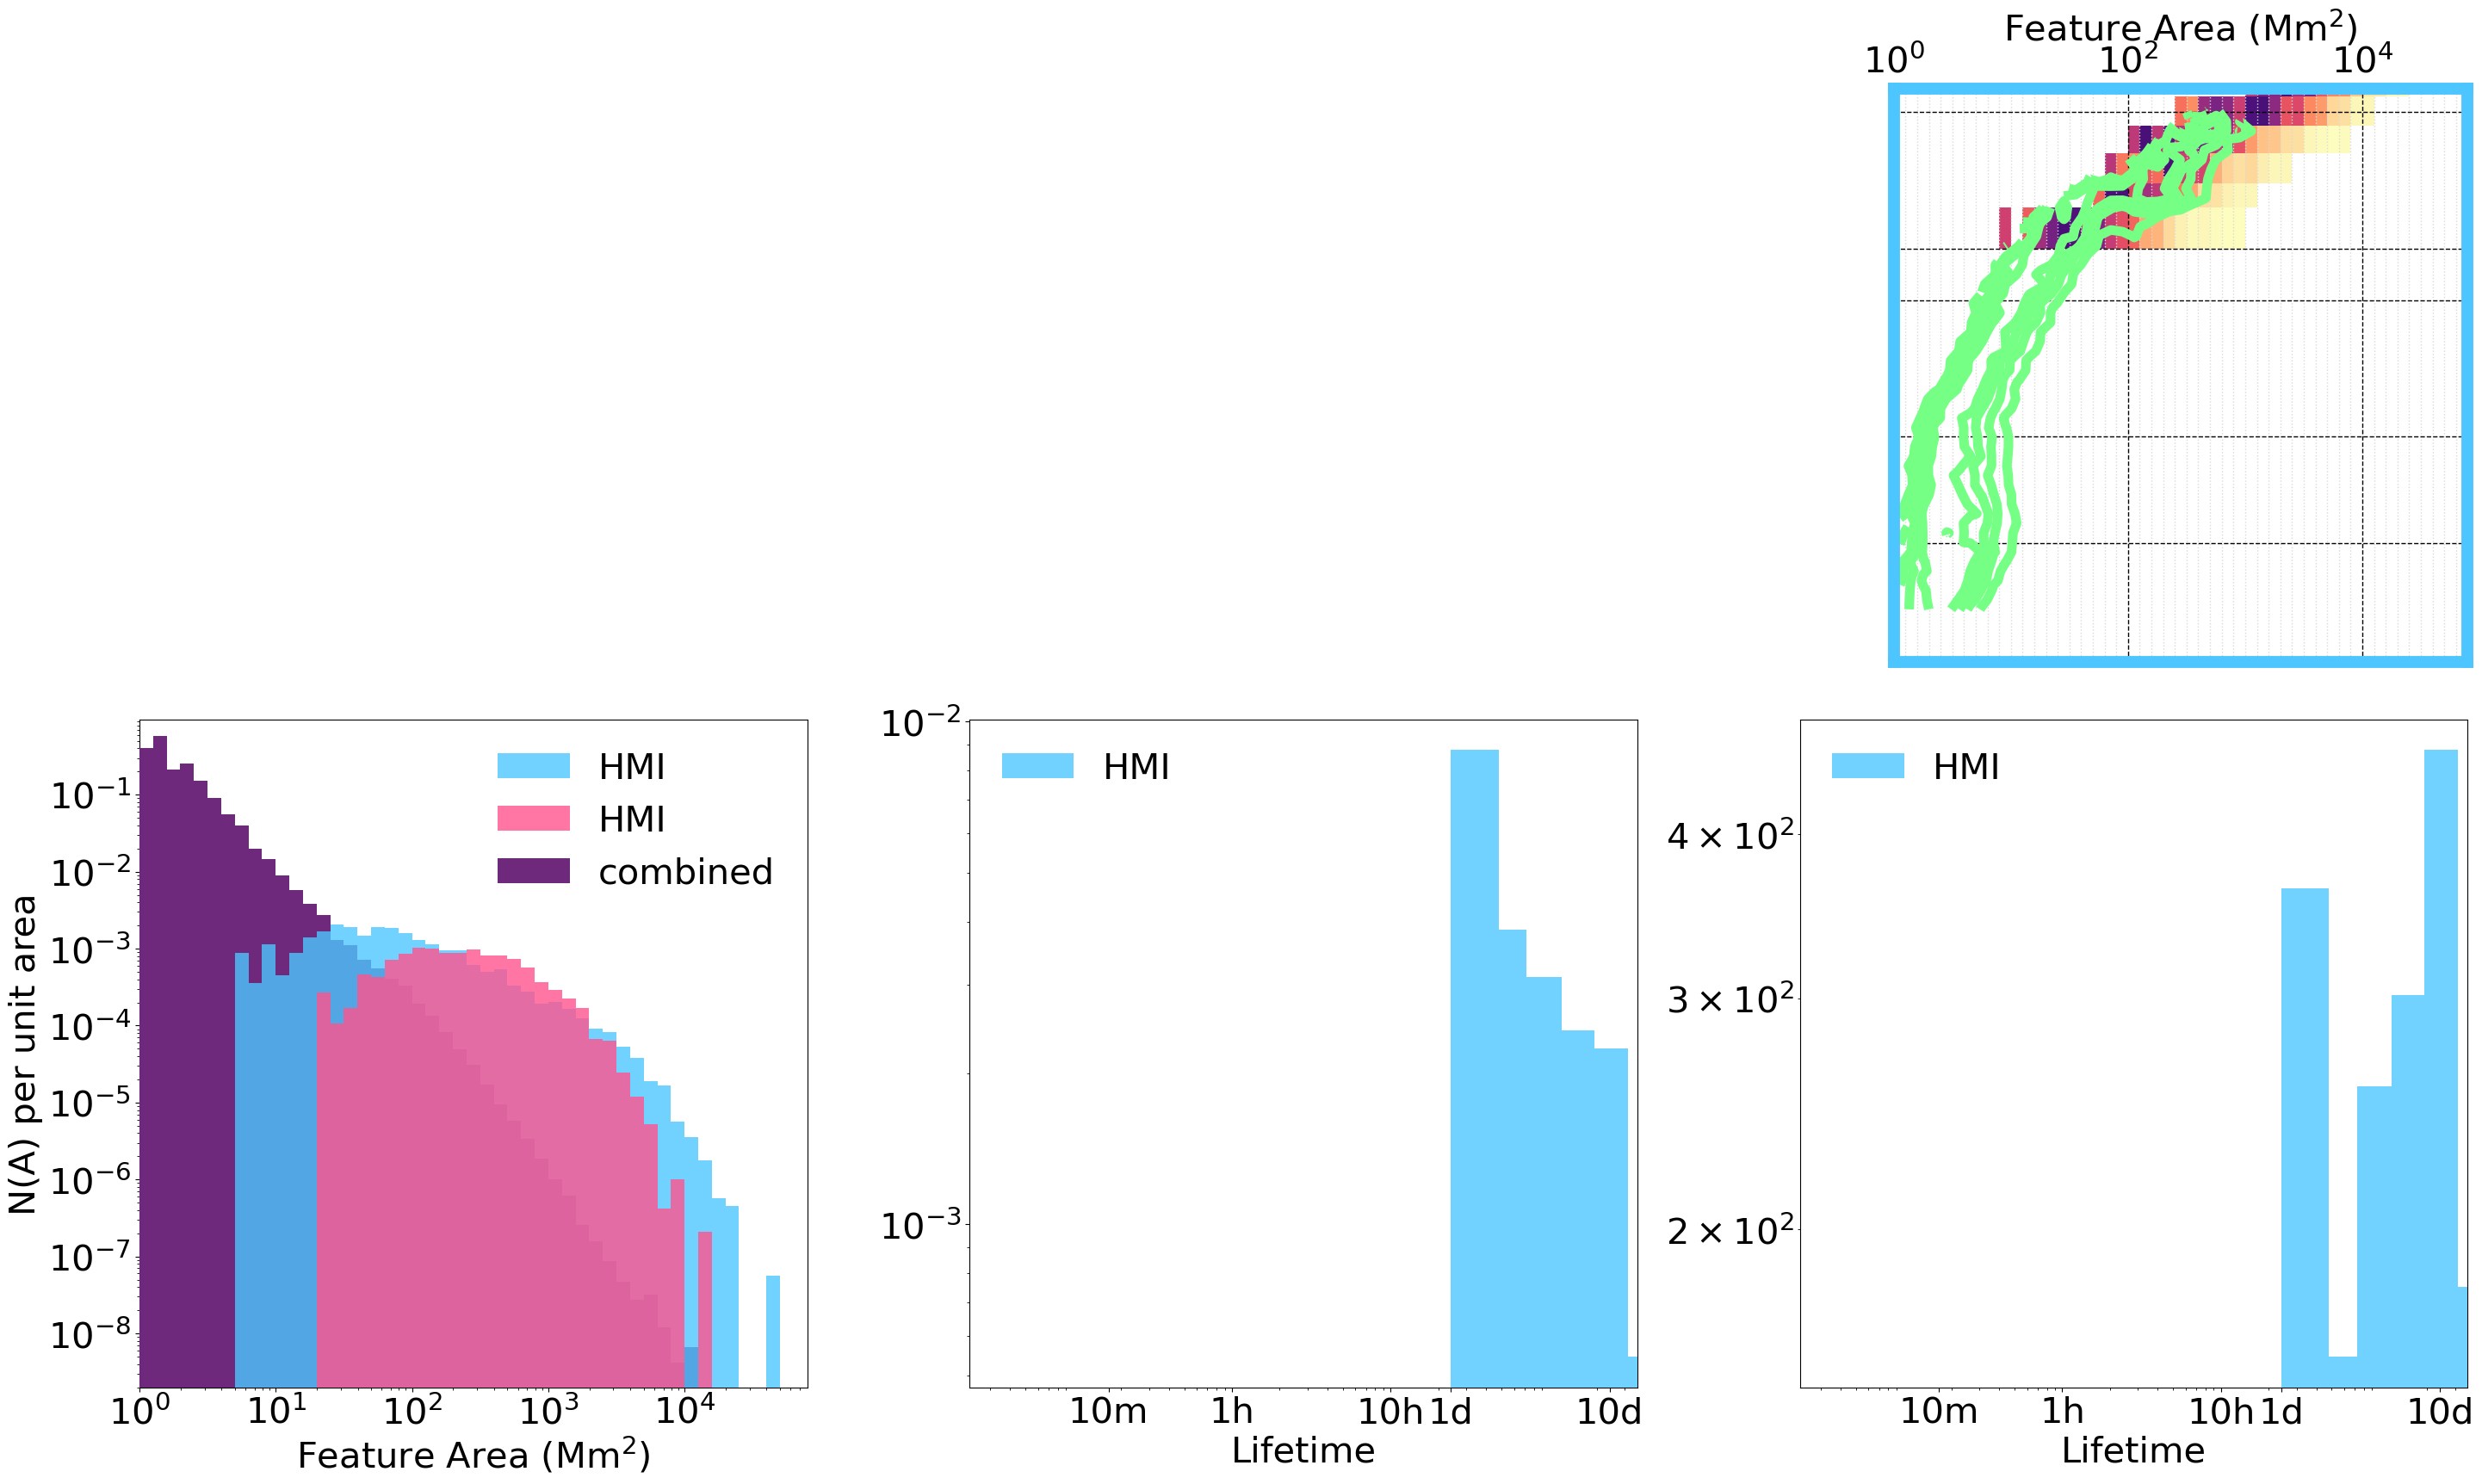

In [24]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 0 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 15 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppxx = pxx/fszh
ppxy = pxy/fszv

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


## Calculate witdth and padding for inner pannels

ppadh3 = ppadh2*15
ppxx2 = (4*ppxx + 3*ppadh2 - ppadh3*2)/3




## Add time distribution axis
ax1 = fig.add_axes([ppadh, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax2 = fig.add_axes([ppadh+ppxx2+ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])

ax4 = fig.add_axes([ppadh+2*ppxx2+2*ppadh3, ppadv - ppadv2 - ppxx2*fszh/fszv, ppxx2, ppxx2*fszh/fszv])


edgesTB = Fibonacci*24



Feature = featuresBARD[instrument]['features']
calibration = featuresBARD[instrument]["calibration"]

# Scatter Plot
ax3 = fig.add_axes([ppadh+(ppxx+ppadh2)*i, ppadv, ppxx, ppxy])

histout = np.histogram2d(sunspot_area['correctedArea']*sunspot_area_calibration, sunspot_area['lifetime'], bins = [edgesA,edgesTB])

print(np.nanmax(sunspot_area['lifetime']))



widthsA = edgesA[1:]-edgesA[0:-1]
hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

hst_nrmA[histout[0]<=2] = np.nan
hst_nrmA = hst_nrmA.T

hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


#--------
# Storing matrices
features[time]['hst'] = histout[0].T
features[time]['hst_nrmA'] = hst_nrmA
features[time]['hst_nrmA_clrN'] = hst_nrmA_clrN

print('hst_nrmA_clrN', np.nanmin(hst_nrmA_clrN), np.nanmax(hst_nrmA_clrN))



# ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
ax3.pcolormesh(edgesA, edgesTB, hst_nrmA_clrN, cmap=plt.cm.magma_r, vmax=1.3)
# ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

ax3.contour((edgesA[0:-1]+edgesA[1:])/2, (edgesT_comb[0:-1]+edgesT_comb[1:])/2, hst_nrmA_clrN_comb, np.linspace(0,1,6), colors=Clr[6], linewidths=8)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(bottom = T1, top = T2);
ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
# ax3.set_xticklabels([])

ax3.set_xlabel('Feature Area (Mm$^2$)')



ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
ax3.xaxis.tick_top()
ax3.minorticks_on()
ax3.set_xticks(edgesA, minor=True)
ax3.set_xticklabels([], minor=True);
ax3.xaxis.set_label_position('top')

ax3.set_yticks([10/60, 1, 10, 24, 240], minor=False)


if i==0 or i==7:
    ax3.set_yticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
    ax3.set_ylabel('Lifetime')
else:
    ax3.set_yticklabels(['', '', '', '', ''] , minor=False)

if i==7:
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position('right')

ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

plt.setp(ax3.spines.values(), color=Clr[i], linewidth=10)        

# if instrument == 'HMI':
ax1.hist(sunspot_area['correctedArea']*sunspot_area_calibration, bins = edgesA, color=Clr[i], alpha=0.8, density = True, label=f'{instrument}', zorder = 2*i+1)
ax2.hist(sunspot_area['lifetime'], bins = edgesTB, color=Clr[i], alpha=0.8, density = True, label=f'{instrument}', zorder= 2*i+1)
ax4.hist(sunspot_area['lifetime'], bins = edgesTB, color=Clr[i], alpha=0.8, density = False, label=f'{instrument}', zorder= 2*i+1 )
print(f'max life for {instrument}', np.nanmax(sunspot_area['lifetime']))
print(f'calibrated max area for {instrument}', np.nanmax(sunspot_area['correctedArea']*sunspot_area_calibration))



ax1.hist(Feature['Area']*calibration, bins = edgesA, color=Clr[2], alpha=0.8, density = True, label=f'{instrument}', zorder = 2*i+1)

ax1.hist(combined_features['Area'], bins = edgesA, color=Clr1[4], alpha=1, density = True, label=f'combined', zorder = 5)
ax1.legend(frameon=False)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

ax1.set_ylim(bottom = 2e-9, top = 0.95)
ax1.set_ylabel('N(A) per unit area')

# ax1.set_xticks(edgesA, minor=False)
# ax1.set_xticklabels([], minor=False)
ax1.set_xlabel('Feature Area (Mm$^2$)');


ax2.legend(frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left = T1, right = T2);

ax2.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax2.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax2.set_xlabel('Lifetime');



ax4.legend(frameon=False)

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left = T1, right = T2);

ax4.set_xticks([10/60, 1, 10, 24, 240], minor=False)
ax4.set_xticklabels(['10m', '1h', '10h', '1d', '10d'] , minor=False)
ax4.set_xlabel('Lifetime');



# fig.savefig('Area_lifetime_RotAssoc.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

C:\Users\Andres\AppData\Local\Temp\ipykernel_169480\3932731792.py:194: RuntimeWarning: invalid value encountered in divide
  hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_169480\3932731792.py:199: RuntimeWarning: All-NaN slice encountered
  hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


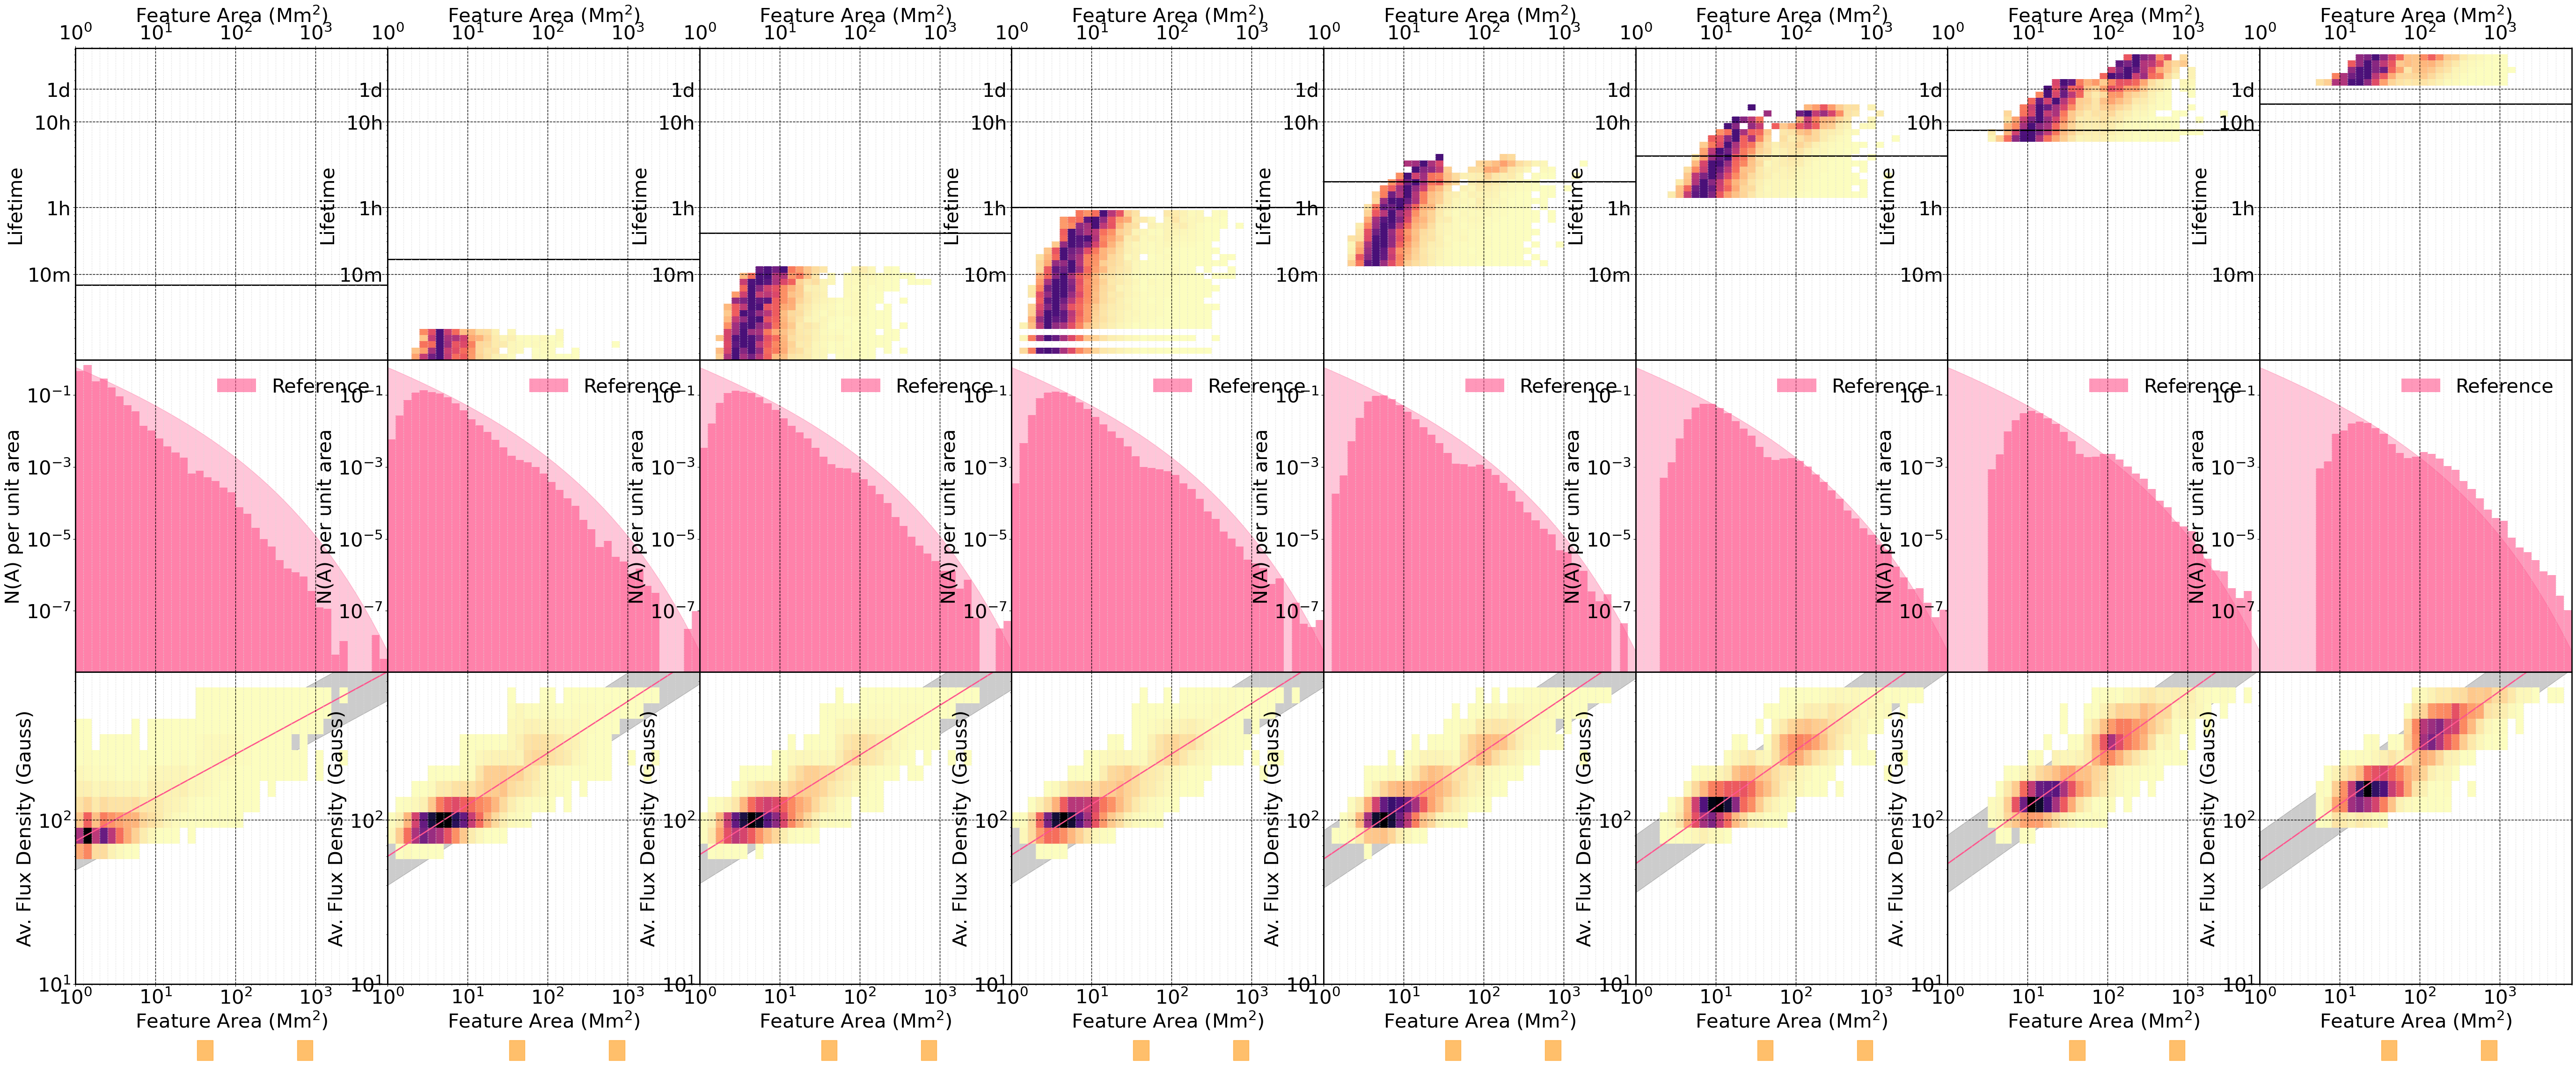

In [131]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


for i in range(8):
    time = 45*2**i

    Feature = features[time]['features']

    ###############################################################################################
    # Area Distribution
    ###############################################################################################

    OrbIn = 55

    # Instrument Definitions
    clr = Clr[4]

    HMIR = 10
    Lat = np.array([60, 55])

    # HMIS = HMIR+Lat*0#2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))
    HMIS = HMIR*2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    Noise = 15
    HMIN = Noise+Lat*0#*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 30/60


    HMIR = 0.5*4
    Lat = np.array([60, 80])

    HMIS = 10*np.divide(1,np.cos((Lat)*np.pi/180))

    Noise = 15
    HMIN = Noise*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 12*2/60


    Nbins = 40
    A1 = 1
    A2 = 1e4
    edgesA = np.power(10,np.arange(np.log10(A1),np.log10(A2),(np.log10(A2)-np.log10(A1))/Nbins))

    # Distribution of areas
    ax1 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])


    ax1.fill_between(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, edgesA*0+2e-9, color=Clr[2], alpha=0.33, zorder = 0)




    ax1.hist(Feature['Area'], bins = edgesA, color=Clr[2], alpha=.6, density = True, zorder=1, label='Reference')
    n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[-1], Feature['meanB']>HMIN[-1]),
                                        np.logical_or((Feature['Life']-1)*time/60>HMIC, (Feature['Life']-1)*time/60==0))], bins = edgesA)
    Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    ax1.legend(frameon=False)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax1.set_ylim(bottom = 2e-9, top = 0.95)
    ax1.set_ylabel('N(A) per unit area')

    ax1.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax1.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax1.minorticks_on()
    ax1.set_xticks(edgesA, minor=True)
    ax1.set_xticklabels([], minor=True);
    ax1.set_xticklabels([])


    ###############################################################################################
    # Flux density vs Area
    ###############################################################################################

    Nbins = 20

    B1 = 10
    B2 = 800
    edgesB = np.power(10,np.arange(np.log10(B1),np.log10(B2),(np.log10(B2)-np.log10(B1))/Nbins))


    # Scatter Plot
    ax2 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv, pxx/fszh*frc, pxy/fszv*frc])
    ax2.hist2d(Feature['Area'], Feature['meanB'], bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)
    # ax1.scatter(Feature['Area'], np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)*Feature['scale'])

    def fit_func(x, a, b):
        return a*np.power(x,b)

    params = curve_fit(fit_func, Feature['Area'].values.astype(float), np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2).values.astype(float))
    [a, b] = params[0]
    ax2.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


    ax2.fill_between(edgesA, fit_func(edgesA, a, b)/1.5, fit_func(edgesA, a, b)*1.5, color='k', alpha=0.2, zorder = 0)
            
    ypos1 = -0.18
    ypos2 = -0.245

    xpos1 = 0 
    xpos2 = 0.05

    totshift = -0.1

    shift = 0.49 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    shift = 0.81 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(bottom = B1, top = B2);
    ax2.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax2.set_xlabel('Feature Area (Mm$^2$)')
    ax2.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax2.minorticks_on()
    ax2.set_xticks(edgesA, minor=True)
    ax2.set_xticklabels([], minor=True);

    ax2.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
    ax2.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    ax2.set_ylabel('Av. Flux Density (Gauss)')


    Nbins = 50

    T1 = 1/60
    T2 = 72
    # edgesT = np.arange(T1,T2)
    edgesT = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))


    # Scatter Plot
    ax3 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+2*pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])

    histout = np.histogram2d(Feature['Area'], (Feature['Life']-1)*time/60/60, bins = [edgesA,edgesT])


    # widthsT = edgesT[1:]-edgesT[0:-1]
    # hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


    widthsA = edgesA[1:]-edgesA[0:-1]
    hst_nrmA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

    hst_nrmA[histout[0]<=2] = np.nan
    hst_nrmA = hst_nrmA.T

    hst_nrmA_clrN = hst_nrmA/np.nanmax(hst_nrmA,axis=1)[:,None]


    #--------
    # Storing matrices
    features[time]['hst'] = histout[0].T
    features[time]['hst_nrmA'] = hst_nrmA
    features[time]['hst_nrmA_clrN'] = hst_nrmA_clrN
    


    # ax3.pcolormesh(edgesA, edgesT, hist_normA, cmap=plt.cm.magma_r)
    ax3.pcolormesh(edgesA, edgesT, hst_nrmA_clrN, cmap=plt.cm.magma_r, vmax=1.3)
    ax3.plot(edgesA, edgesA*0+10*time/60/60, lw=2, color='k', alpha=1)

    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(bottom = T1, top = T2);
    ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
    # ax3.set_xticklabels([])

    ax3.set_xlabel('Feature Area (Mm$^2$)')
    ax3.set_ylabel('Lifetime')


    ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax3.xaxis.tick_top()
    ax3.minorticks_on()
    ax3.set_xticks(edgesA, minor=True)
    ax3.set_xticklabels([], minor=True);
    ax3.xaxis.set_label_position('top')

    ax3.set_yticks([10/60, 1, 10, 24], minor=False)
    ax3.set_yticklabels(['10m', '1h', '10h', '1d'] , minor=False)
    # ax3.set_title('HMI\nRes. 0.5\"\nCad. 30m, Noise 30Gs')

    # ax3.set_yticks([1/60, 2/60, 3/60, 4/60, 5/60, 6/60, 7/60, 8/60, 9/60, 20/60, 30/60, 40/60, 50/60, 2, 3, 4, 5, 6, 7, 8, 9, 48], minor=True)
    # ax3.set_yticklabels(['1m', '2m', '', '', '5m', '', '', '', '', '20m', '', '40m', '', '2h', '', '', '5h', '', '', '', '', '2d'] , minor=True, fontdict= {'fontsize':15});
    ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    # ax3.invert_yaxis()

    for k, spine in ax1.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax2.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax3.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10) 
        spine.set_linewidth(2)
        
    ax1.set_axisbelow(False)
    ax2.set_axisbelow(False)
    ax3.set_axisbelow(False)


KeyError: 'Area'

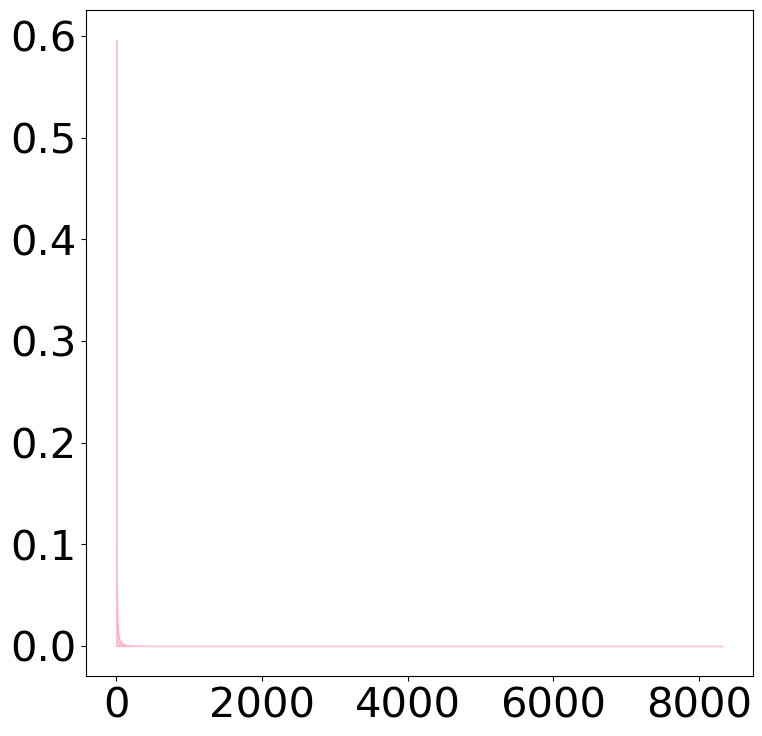

In [ ]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


for i in range(8):
    time = 45*2**i

    Feature = features[time]

    ###############################################################################################
    # HMI
    ###############################################################################################

    OrbIn = 55

    # Instrument Definitions
    clr = Clr[4]

    HMIR = 10
    Lat = np.array([60, 55])

    # HMIS = HMIR+Lat*0#2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))
    HMIS = HMIR*2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    Noise = 15
    HMIN = Noise+Lat*0#*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 30/60


    HMIR = 0.5*4
    Lat = np.array([60, 80])

    HMIS = 10*np.divide(1,np.cos((Lat)*np.pi/180))

    Noise = 15
    HMIN = Noise*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 12*2/60


    Nbins = 50
    A1 = 1
    A2 = 1e4
    edgesA = np.power(10,np.arange(np.log10(A1),np.log10(A2),(np.log10(A2)-np.log10(A1))/Nbins))

    # Distribution of areas
    ax1 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])


    ax1.fill_between(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, edgesA*0+2e-9, color=Clr[2], alpha=0.33, zorder = 0)




    ax1.hist(Feature['Area'], bins = edgesA, color=Clr[2], alpha=.6, density = True, zorder=1, label='Reference')

    # n, bins = np.histogram(Feature['Area'], bins = edgesA)
    # Intg = np.multiply(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1],n)
    # Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # Corr = 0#np.sum(Intg[edgesA[0:edgesA.shape[0]-1]<=HMIS[-1]])
    # ax1.hist(Feature['Area'][np.logical_and(Feature['Area']>HMIS[2], Feature['meanB']>HMIN[2])], bins = edgesA, color=(0.5,0.5,0.5), alpha=1, density = True, zorder=5);

    # n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[0], Feature['meanB']>HMIN[0]),
    #                                       (Feature['Life']-1)*12/60>HMIC)], bins = edgesA)
    # Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.45,0.45,0.45), alpha=1, zorder=zorder)


    n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[-1], Feature['meanB']>HMIN[-1]),
                                        np.logical_or((Feature['Life']-1)*time/60>HMIC, (Feature['Life']-1)*time/60==0))], bins = edgesA)
    Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.65,0.65,0.65), alpha=1, zorder=zorder, label='Observable')


    ax1.legend(frameon=False)

    # s, loc, scale = stats.lognorm.fit(Feature['Area'])
    # print(s,loc,scale)
    # ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

    # # Plot transparency mask
    # for i in np.arange(0,HMIS.shape[0]):
    #     if i==0:
    #         x1 = np.min(edgesA)
    #     else:
    #         x1 = HMIS[i-1]
    #     alphamsk = baseal-delal*i    
    #     ax1.fill([x1, x1, HMIS[i], HMIS[i]], [1e-9, 1, 1, 1e-9], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')

    # s, loc, scale = stats.lognorm.fit(Feature['Area'][Feature['Area']>100],floc=10)
    # print(s,loc,scale)
    # ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

    # s, loc, scale = stats.dweibull.fit(Feature['Area'][Feature['Area']>100])
    # ax1.plot(edgesA, stats.dweibull.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='dweibull pdf')
    # ax1.plot(edgesA, lnwb.pdf(edgesA,0.9, 0.5313502050630872, 5.373345960266665, 0.6, 725.4904206531216, 20), lw=5, alpha=0.6, label='lognorm pdf')

    # ax1.plot(edgesA, lntr.pdf(edgesA, 0.9200010390498645, 4.147854097567208, 20), lw=5, alpha=0.6, label='lognorm pdf')
    # ax1.plot(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, lw=2, color=Clr[2], alpha=1, zorder = zorder+0.2)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax1.set_ylim(bottom = 2e-9, top = 0.95)
    ax1.set_ylabel('N(A) per unit area')

    ax1.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax1.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax1.minorticks_on()
    ax1.set_xticks(edgesA, minor=True)
    ax1.set_xticklabels([], minor=True);
    ax1.set_xticklabels([])


    Nbins = 20

    B1 = 10
    B2 = 800
    edgesB = np.power(10,np.arange(np.log10(B1),np.log10(B2),(np.log10(B2)-np.log10(B1))/Nbins))


    # Scatter Plot
    ax2 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv, pxx/fszh*frc, pxy/fszv*frc])
    ax2.hist2d(Feature['Area'], Feature['meanB'], bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)
    # ax1.scatter(Feature['Area'], np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)*Feature['scale'])

    def fit_func(x, a, b):
        return a*np.power(x,b)

    params = curve_fit(fit_func, Feature['Area'].values.astype(float), np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2).values.astype(float))
    [a, b] = params[0]
    ax2.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


    ax2.fill_between(edgesA, fit_func(edgesA, a, b)/1.5, fit_func(edgesA, a, b)*1.5, color='k', alpha=0.2, zorder = 0)


    # for i in np.arange(0,HMIS.shape[0]):
    #     alphamsk = baseal-delal*i
    #     if i==0:
    #         ax2.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [B1, B2, B2, HMIN[i], HMIN[i], B1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
    #     else:
    #         ax2.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [HMIN[i-1], B2, B2, HMIN[i], HMIN[i], HMIN[i-1]], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
            
            
    ypos1 = -0.18
    ypos2 = -0.245

    xpos1 = 0 
    xpos2 = 0.05

    totshift = -0.1

    shift = 0.49 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    shift = 0.81 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    # ax2.text(totshift, -0.25, 'Not visible for:     $\beta < 60^o$     $\beta < 80^o$', horizontalalignment='left', verticalalignment='bottom',transform=ax2.transAxes)


    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(bottom = B1, top = B2);
    ax2.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax2.set_xlabel('Feature Area (Mm$^2$)')
    ax2.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax2.minorticks_on()
    ax2.set_xticks(edgesA, minor=True)
    ax2.set_xticklabels([], minor=True);

    ax2.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
    # ax2.set_yticklabels(['', '', '', 50, '', '', '', '', '', '', '', 500, '', ''] , minor=True, fontdict= {'fontsize':15})
    ax2.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    ax2.set_ylabel('Av. Flux Density (Gauss)')


    Nbins = 50

    T1 = 1/60
    T2 = 72
    # edgesT = np.arange(T1,T2)
    edgesT = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))


    # Scatter Plot
    ax3 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+2*pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])

    # histout = ax3.hist2d(Feature['Area'], (Feature['Life']-1)*12/60, bins = [edgesA,edgesT], cmap=plt.cm.viridis_r, cmin=1.22e-9, density=True)
    # ax3.scatter(Feature['Area'], Feature['Life']*12/60)

    histout = np.histogram2d(Feature['Area'], (Feature['Life']-1)*time/60/60, bins = [edgesA,edgesT])


    widthsT = edgesT[1:]-edgesT[0:-1]
    hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


    widthsA = edgesA[1:]-edgesA[0:-1]
    hist_normA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

    hist_normA[histout[0]<=2] = np.nan


    ax3.pcolormesh(edgesA, edgesT, hist_normA.T, cmap=plt.cm.magma_r)


    params = curve_fit(fit_func, Feature['Area'].values.astype(float), (Feature['Life'].values.astype(float)-1)*12/60, method='lm')
    [a, b] = params[0]
    ax3.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


    # ax3.fill_between(edgesA, fit_func(edgesA, a, b)/7, fit_func(edgesA, a, b)*7, color='k', alpha=0.2, zorder = 0)


    # # Plot transparency mask
    # for i in np.arange(0,HMIS.shape[0]):
    #     alphamsk = baseal-delal*i
    #     if i==0:
    #         ax3.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [T1, T2, T2, HMIC, HMIC, T1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
    #     else:
    #         ax3.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i]], [HMIC, T2, T2, HMIC], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')


    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(bottom = T1, top = T2);
    ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
    # ax3.set_xticklabels([])

    ax3.set_xlabel('Feature Area (Mm$^2$)')
    ax3.set_ylabel('Lifetime')


    ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax3.xaxis.tick_top()
    ax3.minorticks_on()
    ax3.set_xticks(edgesA, minor=True)
    ax3.set_xticklabels([], minor=True);
    ax3.xaxis.set_label_position('top')

    ax3.set_yticks([10/60, 1, 10, 24], minor=False)
    ax3.set_yticklabels(['10m', '1h', '10h', '1d'] , minor=False)
    # ax3.set_title('HMI\nRes. 0.5\"\nCad. 30m, Noise 30Gs')

    # ax3.set_yticks([1/60, 2/60, 3/60, 4/60, 5/60, 6/60, 7/60, 8/60, 9/60, 20/60, 30/60, 40/60, 50/60, 2, 3, 4, 5, 6, 7, 8, 9, 48], minor=True)
    # ax3.set_yticklabels(['1m', '2m', '', '', '5m', '', '', '', '', '20m', '', '40m', '', '2h', '', '', '5h', '', '', '', '', '2d'] , minor=True, fontdict= {'fontsize':15});
    ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    # ax3.invert_yaxis()

    for k, spine in ax1.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax2.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax3.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10) 
        spine.set_linewidth(2)
        
    ax1.set_axisbelow(False)
    ax2.set_axisbelow(False)
    ax3.set_axisbelow(False)


C:\Users\Andres\AppData\Local\Temp\ipykernel_9876\3899274110.py:246: RuntimeWarning: invalid value encountered in divide
  hist_normA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]
C:\Users\Andres\AppData\Local\Temp\ipykernel_9876\3899274110.py:242: RuntimeWarning: invalid value encountered in divide
  hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


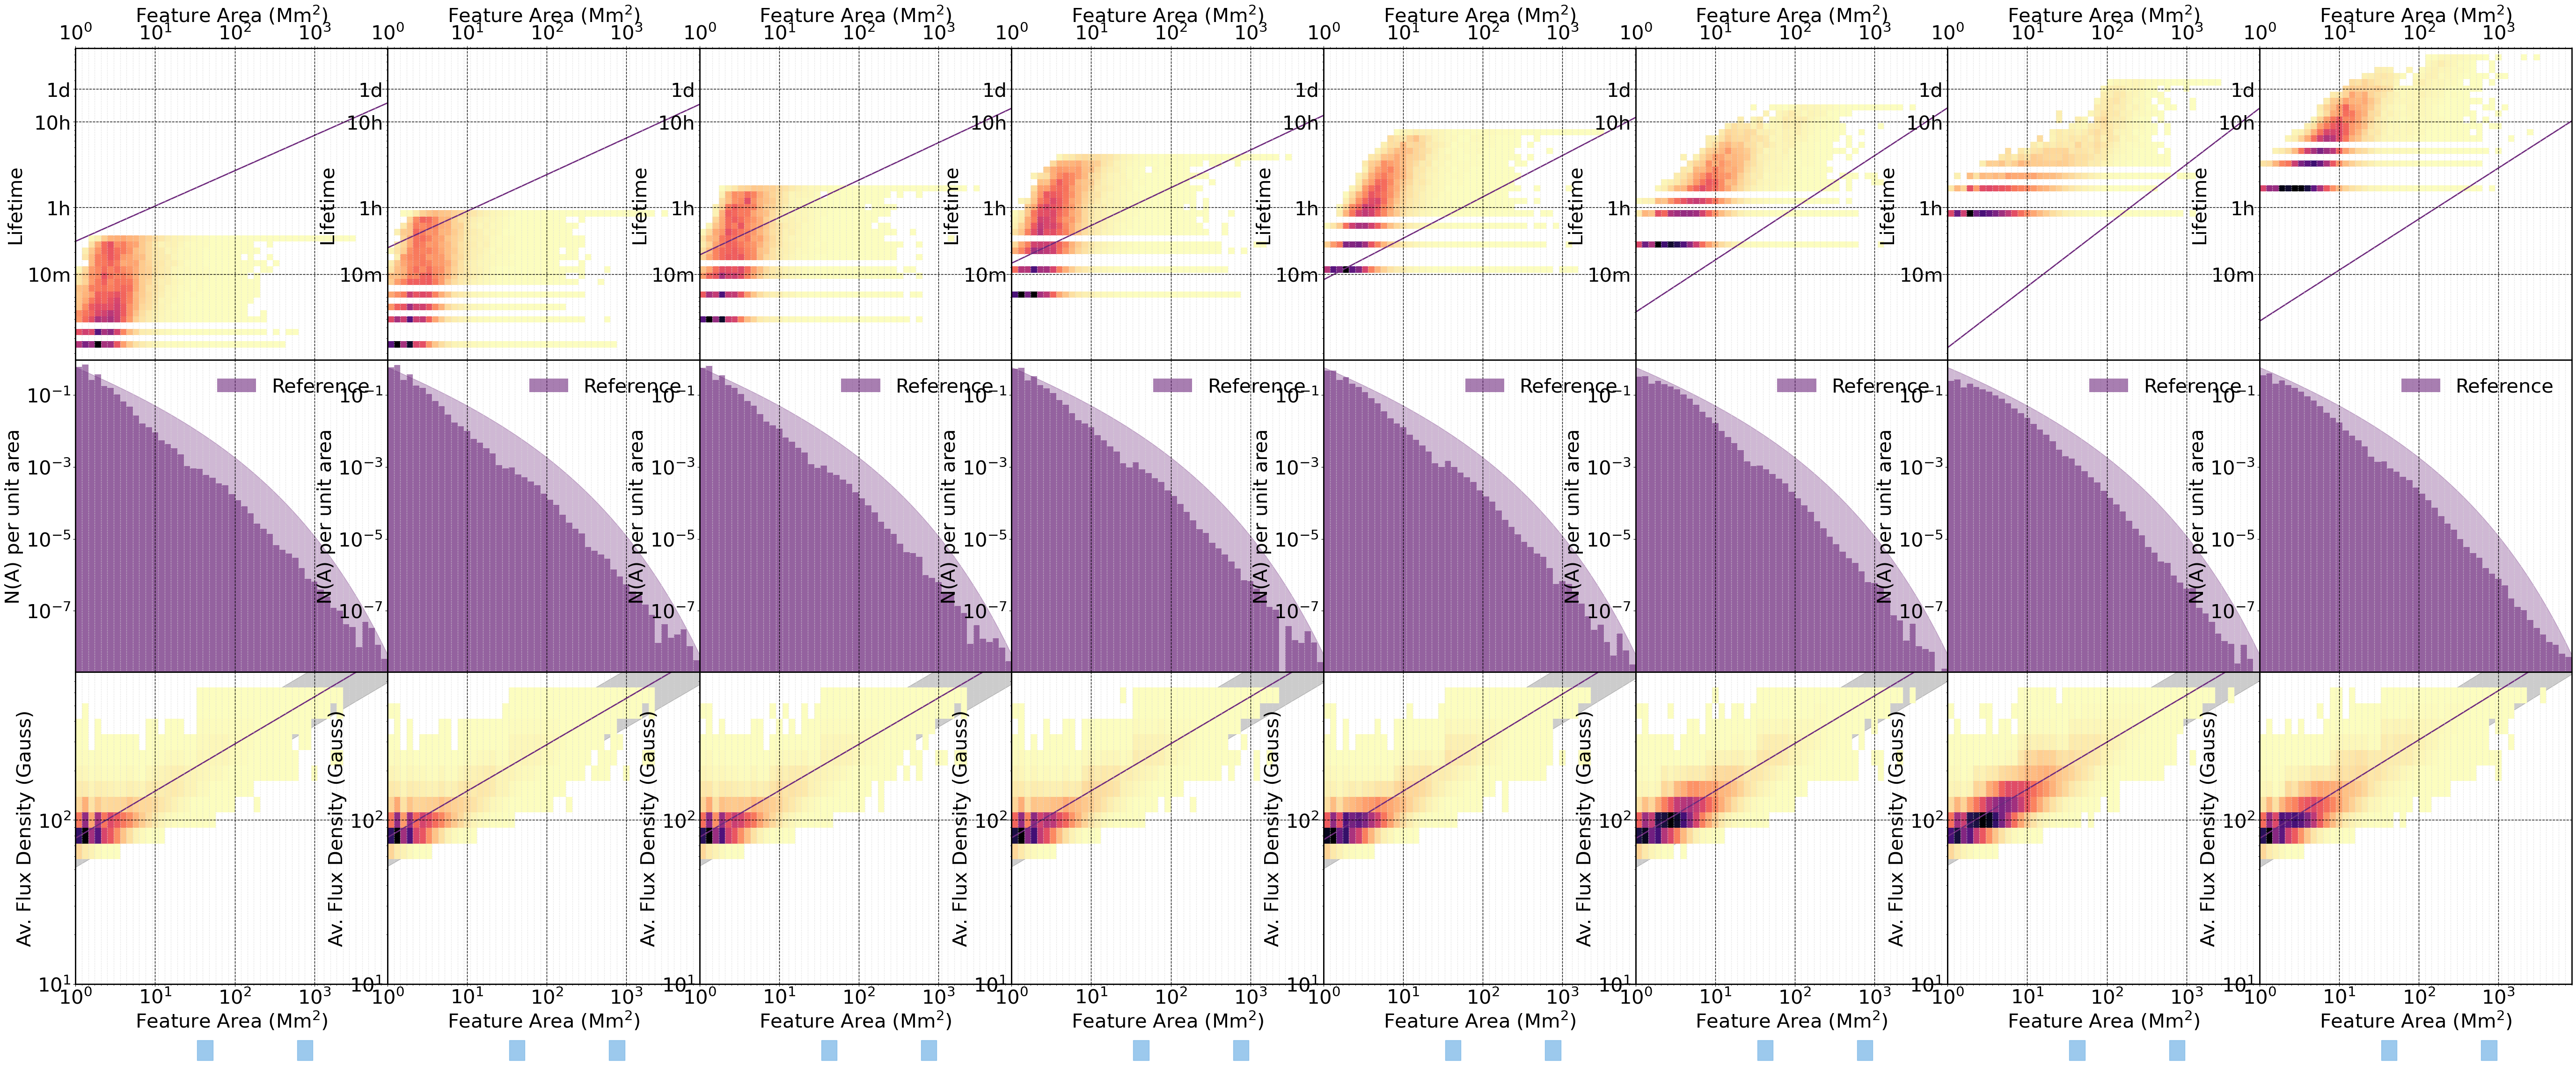

In [ ]:
# Distribution Plots for Observer
zorder = 2
baseal = 0.7
delal = 0.4

OrbIn = 7.155

clrgr = (0.85,0.85,0.85)

plt.rc('font', **font)
# plt.rc('text', usetex=True)


# Size definitions
dpi = 300
pxx = 2000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 8      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


for i in range(8):
    time = 45*2**i

    Feature = features[time]

    ###############################################################################################
    # HMI
    ###############################################################################################

    OrbIn = 55

    # Instrument Definitions
    clr = Clr[4]

    HMIR = 10
    Lat = np.array([60, 55])

    # HMIS = HMIR+Lat*0#2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))
    HMIS = HMIR*2*np.pi*695**2*(HMIR*HMIR)/(np.pi*Rs**2)*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    Noise = 15
    HMIN = Noise+Lat*0#*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 30/60


    HMIR = 0.5*4
    Lat = np.array([60, 80])

    HMIS = 10*np.divide(1,np.cos((Lat)*np.pi/180))

    Noise = 15
    HMIN = Noise*np.divide(1,np.cos((Lat-OrbIn)*np.pi/180))

    HMIC = 12*2/60


    Nbins = 50
    A1 = 1
    A2 = 1e4
    edgesA = np.power(10,np.arange(np.log10(A1),np.log10(A2),(np.log10(A2)-np.log10(A1))/Nbins))

    # Distribution of areas
    ax1 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])


    ax1.fill_between(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, edgesA*0+2e-9, color=Clr[2], alpha=0.33, zorder = 0)




    ax1.hist(Feature['Area'], bins = edgesA, color=Clr[2], alpha=.6, density = True, zorder=1, label='Reference')

    # n, bins = np.histogram(Feature['Area'], bins = edgesA)
    # Intg = np.multiply(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1],n)
    # Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # Corr = 0#np.sum(Intg[edgesA[0:edgesA.shape[0]-1]<=HMIS[-1]])
    # ax1.hist(Feature['Area'][np.logical_and(Feature['Area']>HMIS[2], Feature['meanB']>HMIN[2])], bins = edgesA, color=(0.5,0.5,0.5), alpha=1, density = True, zorder=5);

    # n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[0], Feature['meanB']>HMIN[0]),
    #                                       (Feature['Life']-1)*12/60>HMIC)], bins = edgesA)
    # Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.45,0.45,0.45), alpha=1, zorder=zorder)


    n, bins = np.histogram(Feature['Area'][np.logical_and(np.logical_and(Feature['Area']>HMIS[-1], Feature['meanB']>HMIN[-1]),
                                        np.logical_or((Feature['Life']-1)*time/60>HMIC, (Feature['Life']-1)*time/60==0))], bins = edgesA)
    Dis = np.divide(n,edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1])/Feature['Area'].shape[0]
    # ax1.bar((edgesA[1:edgesA.shape[0]]+edgesA[0:edgesA.shape[0]-1])/2, Dis, width=(edgesA[1:edgesA.shape[0]]-edgesA[0:edgesA.shape[0]-1]), color=(0.65,0.65,0.65), alpha=1, zorder=zorder, label='Observable')


    ax1.legend(frameon=False)

    # s, loc, scale = stats.lognorm.fit(Feature['Area'])
    # print(s,loc,scale)
    # ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

    # # Plot transparency mask
    # for i in np.arange(0,HMIS.shape[0]):
    #     if i==0:
    #         x1 = np.min(edgesA)
    #     else:
    #         x1 = HMIS[i-1]
    #     alphamsk = baseal-delal*i    
    #     ax1.fill([x1, x1, HMIS[i], HMIS[i]], [1e-9, 1, 1, 1e-9], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')

    # s, loc, scale = stats.lognorm.fit(Feature['Area'][Feature['Area']>100],floc=10)
    # print(s,loc,scale)
    # ax1.plot(edgesA, stats.lognorm.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

    # s, loc, scale = stats.dweibull.fit(Feature['Area'][Feature['Area']>100])
    # ax1.plot(edgesA, stats.dweibull.pdf(edgesA, s, loc, scale), 'r-', lw=5, alpha=0.6, label='dweibull pdf')
    # ax1.plot(edgesA, lnwb.pdf(edgesA,0.9, 0.5313502050630872, 5.373345960266665, 0.6, 725.4904206531216, 20), lw=5, alpha=0.6, label='lognorm pdf')

    # ax1.plot(edgesA, lntr.pdf(edgesA, 0.9200010390498645, 4.147854097567208, 20), lw=5, alpha=0.6, label='lognorm pdf')
    # ax1.plot(edgesA, wbtr.pdf(edgesA, 0.3018371092212419, 1.71518801820842, 20, 0, 1)/1.5, lw=2, color=Clr[2], alpha=1, zorder = zorder+0.2)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax1.set_ylim(bottom = 2e-9, top = 0.95)
    ax1.set_ylabel('N(A) per unit area')

    ax1.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax1.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax1.minorticks_on()
    ax1.set_xticks(edgesA, minor=True)
    ax1.set_xticklabels([], minor=True);
    ax1.set_xticklabels([])


    Nbins = 20

    B1 = 10
    B2 = 800
    edgesB = np.power(10,np.arange(np.log10(B1),np.log10(B2),(np.log10(B2)-np.log10(B1))/Nbins))


    # Scatter Plot
    ax2 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv, pxx/fszh*frc, pxy/fszv*frc])
    ax2.hist2d(Feature['Area'], Feature['meanB'], bins = [edgesA,edgesB], cmap=plt.cm.magma_r,cmin=1)
    # ax1.scatter(Feature['Area'], np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2)*Feature['scale'])

    def fit_func(x, a, b):
        return a*np.power(x,b)

    params = curve_fit(fit_func, Feature['Area'].values.astype(float), np.divide(np.abs(Feature['Flux']),Feature['Area']*100000000**2).values.astype(float))
    [a, b] = params[0]
    ax2.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


    ax2.fill_between(edgesA, fit_func(edgesA, a, b)/1.5, fit_func(edgesA, a, b)*1.5, color='k', alpha=0.2, zorder = 0)


    # for i in np.arange(0,HMIS.shape[0]):
    #     alphamsk = baseal-delal*i
    #     if i==0:
    #         ax2.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [B1, B2, B2, HMIN[i], HMIN[i], B1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
    #     else:
    #         ax2.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [HMIN[i-1], B2, B2, HMIN[i], HMIN[i], HMIN[i-1]], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
            
            
    ypos1 = -0.18
    ypos2 = -0.245

    xpos1 = 0 
    xpos2 = 0.05

    totshift = -0.1

    shift = 0.49 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    shift = 0.81 + totshift
    ax2.fill([xpos1+shift, xpos1+shift, xpos2+shift, xpos2+shift], [ypos1, ypos2, ypos2, ypos1], color=clr, alpha = baseal, zorder=zorder, clip_on = False, transform=ax2.transAxes)           

    # ax2.text(totshift, -0.25, 'Not visible for:     $\beta < 60^o$     $\beta < 80^o$', horizontalalignment='left', verticalalignment='bottom',transform=ax2.transAxes)


    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(bottom = B1, top = B2);
    ax2.set_xlim(left = np.min(edgesA), right = np.max(edgesA))

    ax2.set_xlabel('Feature Area (Mm$^2$)')
    ax2.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax2.minorticks_on()
    ax2.set_xticks(edgesA, minor=True)
    ax2.set_xticklabels([], minor=True);

    ax2.set_yticks([20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700], minor=True)
    # ax2.set_yticklabels(['', '', '', 50, '', '', '', '', '', '', '', 500, '', ''] , minor=True, fontdict= {'fontsize':15})
    ax2.set_yticklabels([] , minor=True, fontdict= {'fontsize':15})
    ax2.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    ax2.set_ylabel('Av. Flux Density (Gauss)')


    Nbins = 50

    T1 = 1/60
    T2 = 72
    # edgesT = np.arange(T1,T2)
    edgesT = np.power(10,np.arange(np.log10(T1),np.log10(T2),(np.log10(T2)-np.log10(T1))/Nbins))


    # Scatter Plot
    ax3 = fig.add_axes([ppadh+pxx/fszh*frc*i, ppadv+2*pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*frc])

    # histout = ax3.hist2d(Feature['Area'], (Feature['Life']-1)*12/60, bins = [edgesA,edgesT], cmap=plt.cm.viridis_r, cmin=1.22e-9, density=True)
    # ax3.scatter(Feature['Area'], Feature['Life']*12/60)

    histout = np.histogram2d(Feature['Area'], (Feature['Life']-1)*time/60/60, bins = [edgesA,edgesT])


    widthsT = edgesT[1:]-edgesT[0:-1]
    hist_normT = (histout[0]/widthsT[None,:])/histout[0].sum(1)[:,None]


    widthsA = edgesA[1:]-edgesA[0:-1]
    hist_normA = (histout[0]/widthsA[:,None])/histout[0].sum(0)[None,:]

    hist_normA[histout[0]<=2] = np.nan


    ax3.pcolormesh(edgesA, edgesT, hist_normA.T, cmap=plt.cm.magma_r)


    params = curve_fit(fit_func, Feature['Area'].values.astype(float), (Feature['Life'].values.astype(float)-1)*12/60, method='lm')
    [a, b] = params[0]
    ax3.plot(edgesA, fit_func(edgesA, a, b), lw=2, color=Clr[2], alpha=1)


    # ax3.fill_between(edgesA, fit_func(edgesA, a, b)/7, fit_func(edgesA, a, b)*7, color='k', alpha=0.2, zorder = 0)


    # # Plot transparency mask
    # for i in np.arange(0,HMIS.shape[0]):
    #     alphamsk = baseal-delal*i
    #     if i==0:
    #         ax3.fill([np.min(edgesA), np.min(edgesA), HMIS[i], HMIS[i], np.max(edgesA), np.max(edgesA)], [T1, T2, T2, HMIC, HMIC, T1], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')
    #     else:
    #         ax3.fill([HMIS[i-1], HMIS[i-1], HMIS[i], HMIS[i]], [HMIC, T2, T2, HMIC], color=clr, alpha = alphamsk, zorder=zorder, edgecolor = 'none')


    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylim(bottom = T1, top = T2);
    ax3.set_xlim(left = np.min(edgesA), right = np.max(edgesA))
    # ax3.set_xticklabels([])

    ax3.set_xlabel('Feature Area (Mm$^2$)')
    ax3.set_ylabel('Lifetime')


    ax3.grid(color=clrgr, linestyle=':', linewidth=1, axis='x', which='minor')
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='x', which='major')
    ax3.xaxis.tick_top()
    ax3.minorticks_on()
    ax3.set_xticks(edgesA, minor=True)
    ax3.set_xticklabels([], minor=True);
    ax3.xaxis.set_label_position('top')

    ax3.set_yticks([10/60, 1, 10, 24], minor=False)
    ax3.set_yticklabels(['10m', '1h', '10h', '1d'] , minor=False)
    # ax3.set_title('HMI\nRes. 0.5\"\nCad. 30m, Noise 30Gs')

    # ax3.set_yticks([1/60, 2/60, 3/60, 4/60, 5/60, 6/60, 7/60, 8/60, 9/60, 20/60, 30/60, 40/60, 50/60, 2, 3, 4, 5, 6, 7, 8, 9, 48], minor=True)
    # ax3.set_yticklabels(['1m', '2m', '', '', '5m', '', '', '', '', '20m', '', '40m', '', '2h', '', '', '5h', '', '', '', '', '2d'] , minor=True, fontdict= {'fontsize':15});
    ax3.set_yticklabels([] , minor=True, fontdict= {'fontsize':15});
    ax3.grid(color='k', linestyle='--', linewidth=1, axis='y', which='major')

    # ax3.invert_yaxis()

    for k, spine in ax1.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax2.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)
        spine.set_linewidth(2)
        
    for k, spine in ax3.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10) 
        spine.set_linewidth(2)
        
    ax1.set_axisbelow(False)
    ax2.set_axisbelow(False)
    ax3.set_axisbelow(False)


In [ ]:
Feature['Life']

0         2.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
299105    1.0
299106    1.0
299107    1.0
299108    1.0
299109    1.0
Name: Life, Length: 299110, dtype: float64

(array([2.31449e+05, 3.76390e+04, 1.27780e+04, 0.00000e+00, 6.08700e+03,
        3.38100e+03, 2.06100e+03, 0.00000e+00, 1.32300e+03, 9.68000e+02,
        0.00000e+00, 6.79000e+02, 4.88000e+02, 3.70000e+02, 0.00000e+00,
        3.21000e+02, 2.58000e+02, 0.00000e+00, 1.57000e+02, 1.52000e+02,
        1.37000e+02, 0.00000e+00, 1.09000e+02, 7.90000e+01, 0.00000e+00,
        7.80000e+01, 5.50000e+01, 4.60000e+01, 0.00000e+00, 4.90000e+01,
        4.40000e+01, 3.50000e+01, 0.00000e+00, 2.80000e+01, 2.70000e+01,
        0.00000e+00, 2.60000e+01, 1.80000e+01, 2.30000e+01, 0.00000e+00,
        1.50000e+01, 1.30000e+01, 0.00000e+00, 1.90000e+01, 1.30000e+01,
        1.50000e+01, 0.00000e+00, 1.60000e+01, 1.40000e+01, 1.40000e+02]),
 array([ 1.  ,  1.72,  2.44,  3.16,  3.88,  4.6 ,  5.32,  6.04,  6.76,
         7.48,  8.2 ,  8.92,  9.64, 10.36, 11.08, 11.8 , 12.52, 13.24,
        13.96, 14.68, 15.4 , 16.12, 16.84, 17.56, 18.28, 19.  , 19.72,
        20.44, 21.16, 21.88, 22.6 , 23.32, 24.04, 24.76

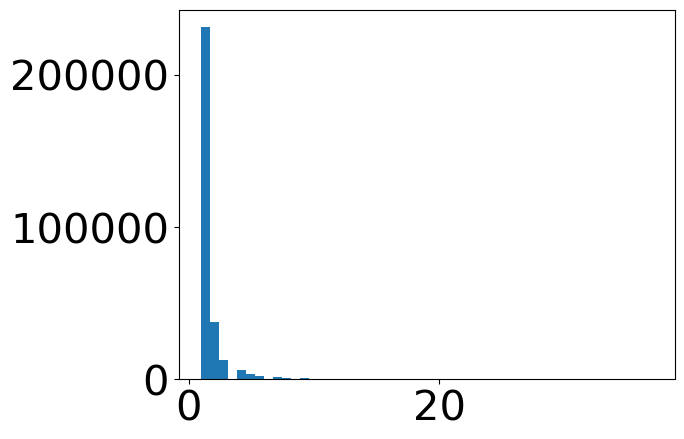

In [ ]:
plt.hist(Feature['Life'],50)